# DEEP LEARNING SPACESHIP TITANIC

## Summary

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

## File and Data Descriptions

1. train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

2. test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
3. sample_submission.csv - A submission file in the correct format.
* PassengerId - Id for each passenger in the test set.
* Transported - The target. For each passenger, predict either True or False.

## Import Relevant Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('future.no_silent_downcasting', True)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

2025-03-04 10:48:45.071485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Import dataframes
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## EDA

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [12]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [13]:
# Get the shape of the training set
df_train.shape

(8693, 14)

In [14]:
# Get the sum of Nan values for each column
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [16]:
# Get the count of num values per column
df_test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

## Training Set EDA and Fill Missing Values

In [18]:
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


### Passenger ID

The passenger ID is the unique identifier for the individual AND the group that they came with, whether it is family or friends. 

So I need to split the group number from the unique identifier.

In [21]:
# Split the group number from the passenger ID into a new column
df_train[['PassengerID', 'GroupNumber']] = df_train['PassengerId'].str.split('_', expand=True)

In [22]:
# Check the new columns with the original passenger ID column
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


### Cabin

I need to split up the cabin column by deck, num, and side.

In [25]:
df_train['Cabin'].value_counts(dropna=False)

Cabin
NaN        199
G/734/S      8
C/137/S      7
B/201/P      7
G/109/P      7
          ... 
G/556/P      1
E/231/S      1
G/545/S      1
G/543/S      1
C/178/S      1
Name: count, Length: 6561, dtype: int64

In [26]:
# Split the Cabin column into Deck, Num, and Side
df_train[['Deck', 'CabinNum', 'Side']] = df_train['Cabin'].str.split('/', expand=True)

# Convert CabinNum to numeric (optional)
df_train['CabinNum'] = pd.to_numeric(df_train['CabinNum'], errors='coerce')

# Drop the Cabin column
df_train = df_train.drop(columns='Cabin')

In [27]:
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0
Spa,0.0,549.0,6715.0,3329.0,565.0


### Home Planet

Graph the Home Planet and Transported columns to see if there if some sort of correlation. 

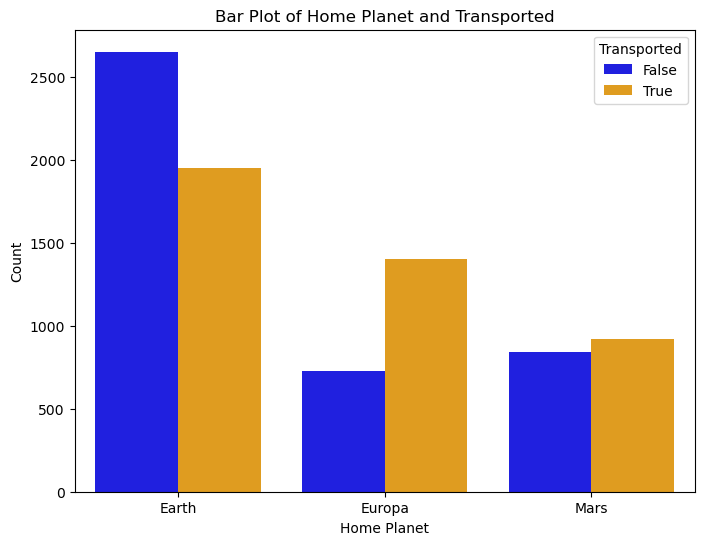

In [30]:
# Group the data
df_grouped = df_train.groupby(['HomePlanet', 'Transported']).size().reset_index(name='Count')

# Ensure categorical data types
df_grouped['HomePlanet'] = df_grouped['HomePlanet'].astype(str)

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_grouped, x='HomePlanet', y='Count', hue='Transported', palette=["blue", "orange"])

# Labels and title
plt.xlabel('Home Planet')
plt.ylabel('Count')
plt.title('Bar Plot of Home Planet and Transported')

plt.show()

**Observations**:
- Earth:
    - Most individuals are from Earth.
    - More individuals were not transported (False, blue) than transported (True, orange).
- Europa:
    - Fewer individuals overall compared to Earth.
    - More individuals were transported (True, orange) than not transported.
- Mars:
    - The counts of transported and non-transported individuals are nearly equal.

**Key Takeaways**:
- Individuals from Europa are more likely to be transported than not.
- Earth has the highest count overall, but more people from Earth remain untransported.
- Mars has relatively balanced transportation outcomes.

In [31]:
# Get the value counts of the Home Planet column
df_train['HomePlanet'].value_counts(dropna=False)

HomePlanet
Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: count, dtype: int64

Fill in the missing values for Home Planet.

In [33]:
df_train['GroupNumber'].value_counts(dropna=False)

GroupNumber
01    6217
02    1412
03     571
04     231
05     128
06      75
07      46
08      13
Name: count, dtype: int64

I want to fill the missing values in the Home Planet column with the like members in the group column. My reasoning is that the people in the same group are from the same planet, therefore I can fill those missing values with passengers in the same group.

Also, there are no missing values in the GroupNumber column, which makes it easier to use it as a groupby to fill.

But first, lets check and see if the group numbers correspond to the planet of origin.

In [36]:
# Groupby Group Number and Home Planet
grouped_df = pd.DataFrame(df_train.groupby(['GroupNumber', 'HomePlanet']).size())
grouped_df

0
GroupNumber HomePlanet      
01          Earth       3593
            Europa      1260
            Mars        1223
02          Earth        525
            Europa       517
            Mars         334
03          Earth        235
            Europa       189
            Mars         135
04          Earth         91
            Europa        95
            Mars          39
05          Earth         67
            Europa        45
            Mars          14
06          Earth         47
            Europa        18
            Mars           7
07          Earth         31
            Europa         7
            Mars           7
08          Earth         13

We grouped by Group Number and Home Planet.

Next, we will fill the missing values with the most common value within the group. 

In [38]:
# Group by 'GroupNumber' and fill NaN in 'HomePlanet' with the most common value within each group
df_train['HomePlanet'] = df_train.groupby(['GroupNumber'])['HomePlanet'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)

In [39]:
df_train['HomePlanet'].value_counts(dropna=False)

HomePlanet
Earth     4797
Europa    2137
Mars      1759
Name: count, dtype: int64

### Cryo Sleep

In [41]:
df_train['CryoSleep'].value_counts(dropna=False)

CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

Graph the Cyro Sleep and Transported columns to see if there is a correlation.

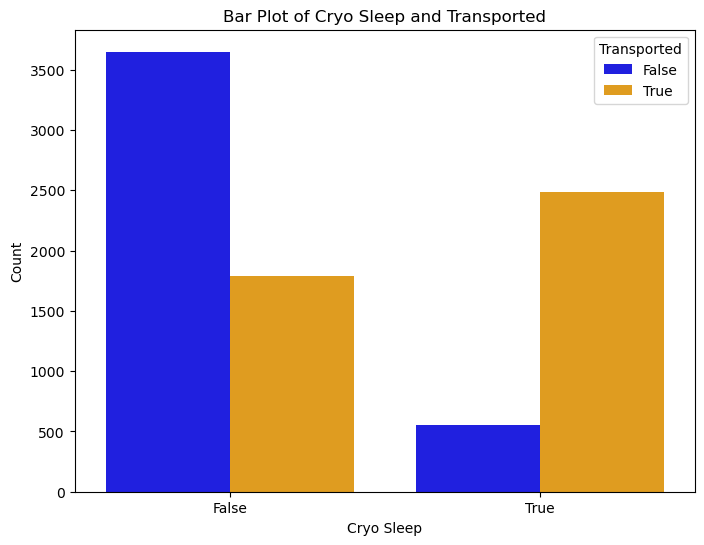

In [43]:
# Group the data
df_grouped = df_train.groupby(['CryoSleep', 'Transported']).size().reset_index(name='Count')

# Ensure categorical data types
df_grouped['CryoSleep'] = df_grouped['CryoSleep'].astype(str)
df_grouped['Transported'] = df_grouped['Transported'].astype(str)

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_grouped, x='CryoSleep', y='Count', hue='Transported', palette=["blue", "orange"])

# Labels and title
plt.xlabel('Cryo Sleep')
plt.ylabel('Count')
plt.title('Bar Plot of Cryo Sleep and Transported')

# Fix the legend colors
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, title='Transported')

plt.show()

**Observations**
- False (Not in Cryo Sleep):
    - The majority of individuals were not in cryo sleep.
    - Most of them were not transported (False, blue).
    - A smaller but significant portion were transported (True, orange).
- True (In Cryo Sleep):
    - Fewer individuals were in cryo sleep overall.
    - The majority of them were transported (True, orange).
    - Very few individuals in cryo sleep were not transported (False, blue).

**Key Takeaways**
- Individuals in Cryo Sleep were much more likely to be transported than not.
- Most non-Cryo Sleep individuals were not transported, indicating a possible correlation between cryo sleep and transportation likelihood.

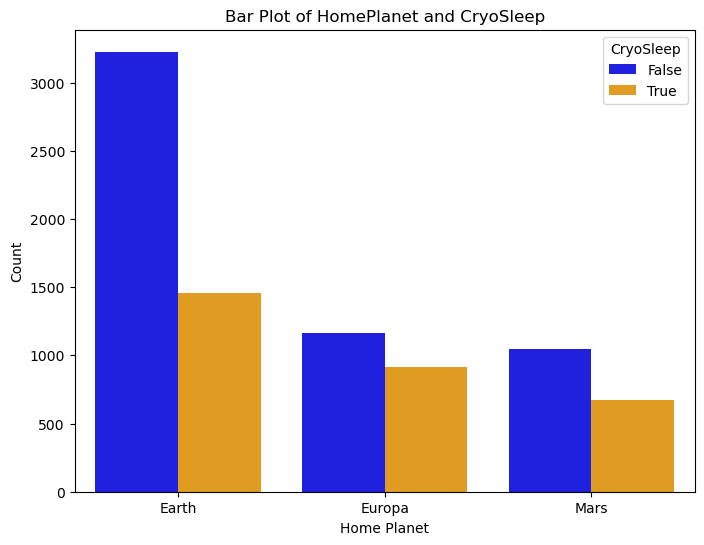

In [45]:
# Group the data
df_grouped = df_train.groupby(['HomePlanet', 'CryoSleep']).size().reset_index(name='Count')

# Ensure categorical data types
df_grouped['HomePlanet'] = df_grouped['HomePlanet'].astype(str)
df_grouped['CryoSleep'] = df_grouped['CryoSleep'].astype(str)

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_grouped, x="HomePlanet", y="Count", hue="CryoSleep", palette=["blue", "orange"])

# Labels and title
plt.xlabel("Home Planet")
plt.ylabel("Count")
plt.title("Bar Plot of HomePlanet and CryoSleep")

plt.show()

**Observations**
- Earth:
    - The majority of individuals are from Earth.
    - Most of them were not in cryo sleep (False, blue).
    - A smaller proportion were in cryo sleep (True, orange).
- Europa:
    - The number of people from Europa is much smaller than Earth.
    - The count of non-cryosleep (blue) and cryosleep (orange) individuals is more balanced compared to Earth.
- Mars:
    - The smallest number of individuals come from Mars.
    - The majority of Mars inhabitants were not in cryo sleep (False, blue) but there is still a noticeable portion in cryo sleep (True, orange).


**Key Takeaways**
- Earth has the highest population overall, and most people from Earth are NOT in cryo sleep.
- Europa has a more balanced proportion of cryo sleep and non-cryo sleep individuals compared to other planets.
- Mars has fewer people in cryo sleep than not, similar to Earth but on a smaller scale.

In [47]:
grouped_df = pd.DataFrame(df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep']).size())
grouped_df

0
HomePlanet GroupNumber CryoSleep      
Earth      01          False      2606
                       True       1042
           02          False       343
                       True        199
           03          False       133
                       True        111
           04          False        52
                       True         35
           05          False        38
                       True         28
           06          False        29
                       True         20
           07          False        18
                       True         14
           08          False         7
                       True          6
Europa     01          False       697
                       True        529
           02          False       266
                       True        238
           03          False       107
                       True         74
           04          False        61
                       True         38
           05          False        20
                       True         24
           06          False        13
                       True          5
           07          False         2
                       True          5
Mars       01          False       735
                       True        459
           02          False       198
                       True        126
           03          False        71
                       True         61
           04          False        26
                       True         13
           05          False         9
                       True          5
           06          False         4
                       True          3
           07          False         4
                       True          2

Let's fill the Nan values in Cryo Sleep with the mode of the group Home Planet, GroupNumber and CryoSleep.

In [49]:
# Use groupby to fill the mode of the group
df_train['CryoSleep'] = df_train.groupby(['HomePlanet', 'GroupNumber'])['CryoSleep'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

In [50]:
# Check for remaining Nan Values if any
df_train['CryoSleep'].value_counts(dropna=False)

CryoSleep
False    5655
True     3038
Name: count, dtype: int64

### Destination

In [52]:
# Get the value counts of the destination column
df_train['Destination'].value_counts(dropna=False)

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: count, dtype: int64

Graph the Destination and Home Planet

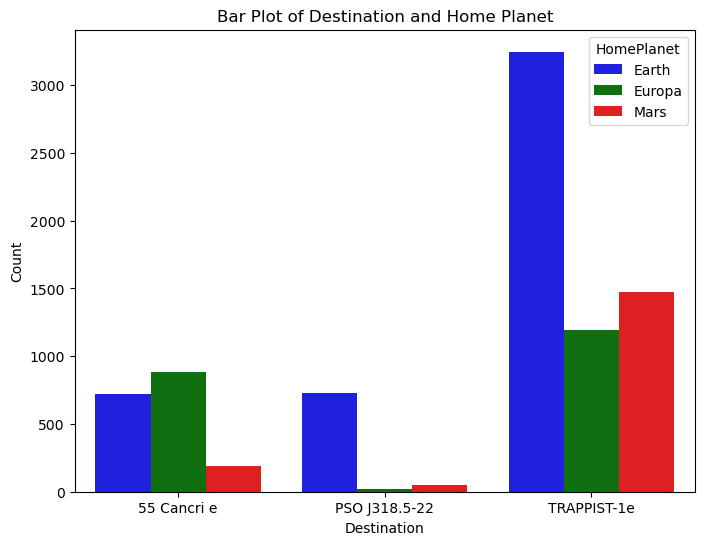

In [54]:
# Group the data
df_grouped = df_train.groupby(['HomePlanet', 'Destination']).size().reset_index(name='Count')

# Ensure categorical data types
df_grouped['HomePlanet'] = df_grouped['HomePlanet'].astype(str)
df_grouped['Destination'] = df_grouped['Destination'].astype(str)

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_grouped, x='Destination', y='Count', hue='HomePlanet', palette=['blue', 'green','red'])

# Labels and title
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Bar Plot of Destination and Home Planet')

plt.show()

Observations:
1. TRAPPIST-1e is the most popular destination overall, with the highest number of travelers, particularly from Earth.
2. 55 Cancri e has more balanced distribution, with a significant number of travelers from both Earth and Europa.
3. PSO J318.5-22 has the lowest number of travelers, with most coming from Earth and very few from Europa and Mars.
4. Mars travelers are fewer overall, but a notable number are traveling to TRAPPIST-1e.

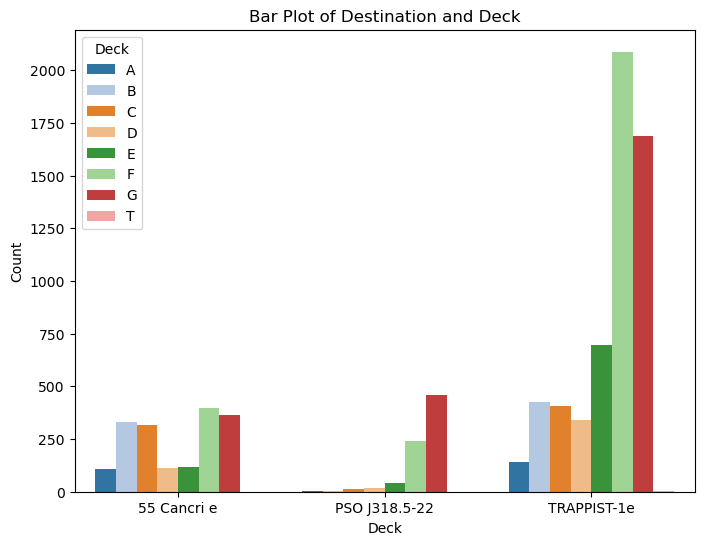

In [56]:
# Group the data
df_grouped = df_train.groupby(['Deck', 'Destination']).size().reset_index(name='Count')

# Ensure categorical data types
df_grouped['Deck'] = df_grouped['Deck'].astype(str)
df_grouped['Destination'] = df_grouped['Destination'].astype(str)

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_grouped, x='Destination', y='Count', hue='Deck', palette='tab20')

# Labels and title
plt.xlabel('Deck')
plt.ylabel('Count')
plt.title('Bar Plot of Destination and Deck')

plt.show()

Observations:
1. TRAPPIST-1e is the most popular destination overall, with the highest number of travelers, particularly from Deck F and Deck G.
2. 55 Cancri e has a relatively balanced distribution of travelers across different decks, with Decks B, C, F, and G being the most common.
3. PSO J318.5-22 has significantly fewer travelers compared to the other two destinations.
4. Deck F and Deck G dominate TRAPPIST-1e, suggesting these decks may have more travelers or be the most common for long-distance travel.


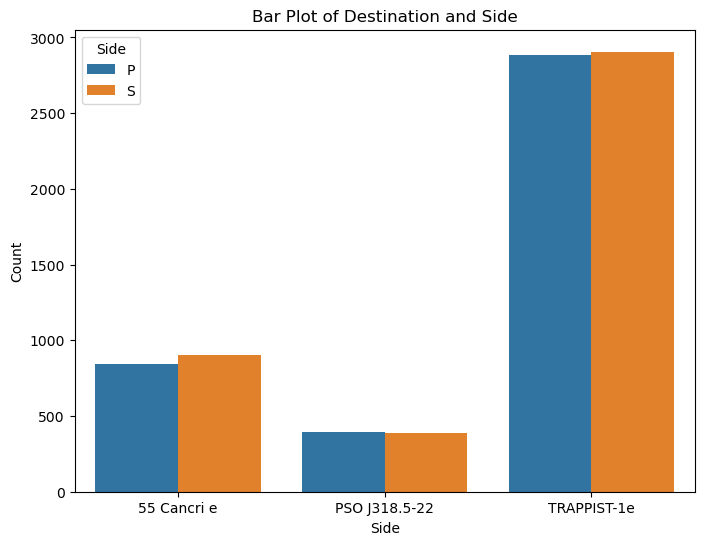

In [58]:
# Group the data
df_grouped = df_train.groupby(['Side', 'Destination']).size().reset_index(name='Count')

# Ensure categorical data types
df_grouped['Side'] = df_grouped['Side'].astype(str)
df_grouped['Destination'] = df_grouped['Destination'].astype(str)

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_grouped, x='Destination', y='Count', hue='Side', palette='tab10')

# Labels and title
plt.xlabel('Side')
plt.ylabel('Count')
plt.title('Bar Plot of Destination and Side')

plt.show()

**Observations**
- 55 Cancri e:
    - The number of people on Side P and Side S is nearly equal, with Side S slightly higher.
- PSO J318.5-22:
    - This destination has the lowest number of travelers overall.
    - The counts for Side P and Side S are very close, indicating a balanced distribution.
- TRAPPIST-1e:
    - This destination has the highest number of travelers.
    - The counts of Side P and Side S are nearly identical.

**Key Takeaways**
- TRAPPIST-1e is the most popular destination, with a large number of people on both Side P and Side S.
- 55 Cancri e has fewer travelers, but a slightly higher number on Side S than Side P.
PSO J318.5-22 has the least number of travelers, but both sides are nearly equal in count.

In [60]:
# Make a groupby dataframe with HomePlanet, GroupNumber and Cryosleep
df_grouped = pd.DataFrame(df_train.groupby(['HomePlanet', 'GroupNumber','CryoSleep','Destination'])['Destination'].size())
df_grouped

Destination
HomePlanet GroupNumber CryoSleep Destination               
Earth      01          False     55 Cancri e            385
                                 PSO J318.5-22          302
                                 TRAPPIST-1e           1933
                       True      55 Cancri e            151
                                 PSO J318.5-22          281
...                                                     ...
Mars       06          True      55 Cancri e              1
                                 TRAPPIST-1e              2
           07          False     55 Cancri e              1
                                 TRAPPIST-1e              4
                       True      TRAPPIST-1e              1

[110 rows x 1 columns]

In [61]:
# Fill the missing values with the Mode of the previous groupby
df_train['Destination'] = df_train.groupby(['HomePlanet','CryoSleep'])['Destination'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

In [62]:
# Check the column for missing values
df_train['Destination'].value_counts(dropna=False)

Destination
TRAPPIST-1e      6097
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

### Age

In [64]:
# Get the value counts for the Age column
df_train['Age'].value_counts(dropna=False)

Age
24.0    324
18.0    320
21.0    311
19.0    293
23.0    292
       ... 
72.0      4
78.0      3
79.0      3
76.0      2
77.0      2
Name: count, Length: 81, dtype: int64

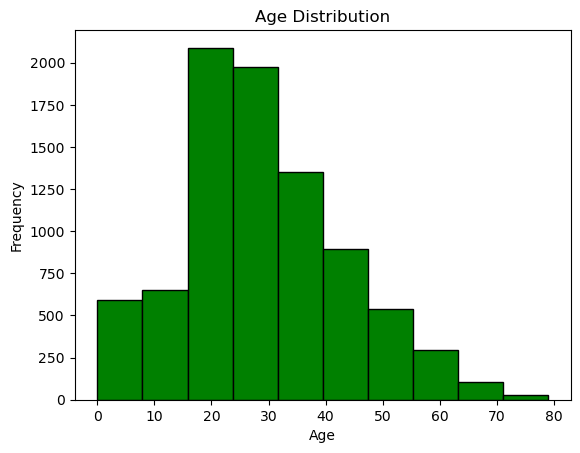

In [65]:
# Plot a histogram of the 'Age' column
plt.hist(df_train['Age'], bins=10, color='green', edgecolor='black')

# Title and labels
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

Observations:
1. Most travelers are young adults (20-30 years old):
    - The highest frequency is in the 20-30 age range, peaking at around 2100 individuals.
    - The next highest age group is 10-20 years old.
2. The distribution is right-skewed:
    - There are fewer older individuals (50+ years old).
    - The number of individuals declines steadily after age 30.
3. Children and teenagers (0-10 years old) make up a smaller portion but still have a noticeable presence.

4. There are very few people above 70 years old.

Conclusion:  
 - The dataset consists mostly of young travelers (20-30 years old).
 - Older individuals are less frequent, suggesting space travel may be more common among younger populations.

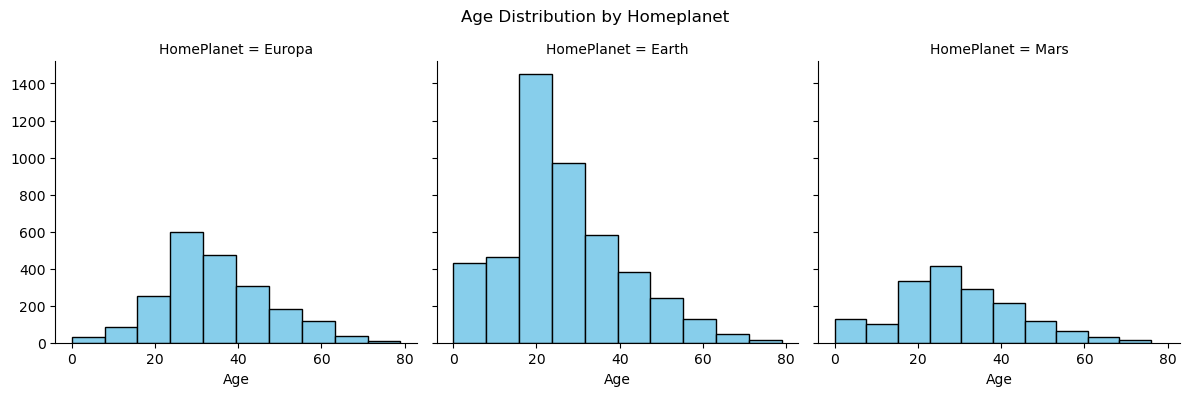

In [67]:
# Create a FacetGrid to plot the distribution of ages for each homeplanet
g = sns.FacetGrid(df_train, col='HomePlanet', col_wrap=3, height=4, aspect=1)
g.map(plt.hist, 'Age', bins=10, color="skyblue", edgecolor="black")

# Add a title to the whole figure
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Age Distribution by Homeplanet')

plt.show()

Key Observations:
1. Earth has the largest population
    - The highest peak is seen in the 20-30 age range, with over 1400 individuals.
    - The age distribution is right-skewed, meaning younger individuals dominate.
2. Europa and Mars have similar distributions
    - Both have smaller populations compared to Earth.
    - The peak age group is around 30-40 years old, which is slightly older than Earth's peak.
    - The distribution for both planets is more spread out, meaning a wider range of ages is represented.
3. Older travelers (50+ years old) are uncommon across all planets
    - Most travelers are under 50, but there are a few older individuals from each planet.

Comparative Insights:
- Earth travelers tend to be younger, with a peak around 20-30 years old.
- Europa and Mars travelers tend to be slightly older, with peaks around 30-40 years old.
- Fewer young children (under 10) are present in all three home planets.

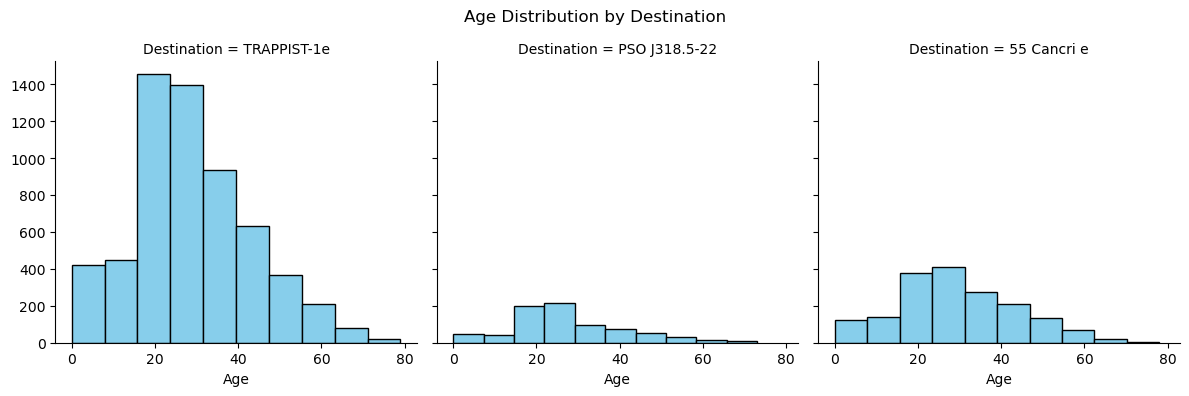

In [69]:
# Create a FacetGrid to plot the distribution of ages for each Destination
g = sns.FacetGrid(df_train, col='Destination', col_wrap=3, height=4, aspect=1)
g.map(plt.hist, 'Age', bins=10, color="skyblue", edgecolor="black")

# Add a title to the whole figure
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Age Distribution by Destination')

plt.show()

Key Observations:
1. TRAPPIST-1e has the highest number of travelers
    - The 20-30 age group dominates, with over 1400 individuals in that range.
    - The distribution is right-skewed, meaning younger travelers are more common.
2. PSO J318.5-22 has the fewest travelers
    - The age distribution is flatter, meaning there is no strong peak in any specific age group.
    - The majority of travelers fall between 10 and 50 years old.
55 Cancri e has a moderate number of travelers
    - The age distribution is more balanced compared to TRAPPIST-1e.
    - The peak is around the 30-40 age range, slightly older than TRAPPIST-1e travelers.
    - There is a noticeable presence of older travelers (50+ years old) compared to the other destinations.
Comparative Insights:  
- TRAPPIST-1e attracts the youngest travelers, with a peak at 20-30 years old.
- 55 Cancri e travelers tend to be slightly older, with a broader age range.
- PSO J318.5-22 has a more evenly distributed age range, but significantly fewer travelers overall.

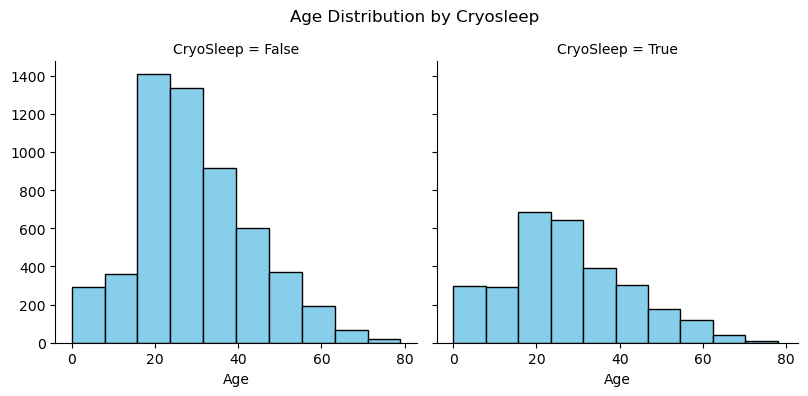

In [71]:
# Create a FacetGrid to plot the distribution of ages for Cryosleep or Not under Cryosleep
g = sns.FacetGrid(df_train, col='CryoSleep', col_wrap=3, height=4, aspect=1)
g.map(plt.hist, 'Age', bins=10, color="skyblue", edgecolor="black")

# Add a title to the whole figure
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Age Distribution by Cryosleep', x=0.35)

plt.show()

Key Observations:
1. More travelers are not in CryoSleep (CryoSleep = False)
    - The 20-30 age group dominates, with over 1400 individuals in that range.
    - The distribution is right-skewed, meaning younger individuals are more common.
    - Very few travelers above 60 years old.
2. Fewer travelers were in CryoSleep (CryoSleep = True)
    - The peak is around 20-30 years old, but the overall numbers are lower than in the non-CryoSleep group.
    - A broader spread of ages is seen in this group compared to those not in CryoSleep.
    - Still, the number of travelers over 60 years old is minimal.
Comparative Insights:
- Most travelers not in CryoSleep are young adults (20-30 years old).
- The CryoSleep group is smaller but has a similar distribution.
- Older individuals (50+ years) are less common in both groups.
- The peak age range is lower for non-CryoSleep travelers, indicating younger people are more likely to stay awake.

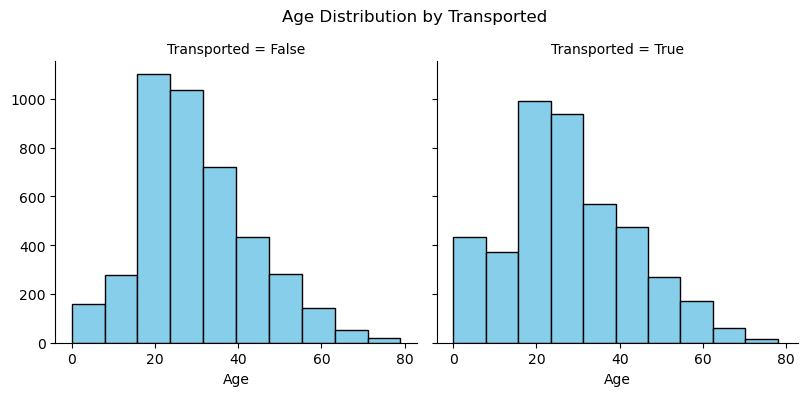

In [73]:
# Create a FacetGrid to plot the distribution of ages for Transported or Not Transported
g = sns.FacetGrid(df_train, col='Transported', col_wrap=3, height=4, aspect=1)
g.map(plt.hist, 'Age', bins=10, color='skyblue', edgecolor='black')

# Add a title to the whole figure
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Age Distribution by Transported', x=0.35)

plt.show()

Key Observations:
1. The distributions for both "Transported = False" and "Transported = True" are very similar
    - Both groups have a peak in the 20-30 age range, indicating that most travelers in this dataset are young adults.
    - The frequency of travelers decreases steadily after age 30.
    - There are very few travelers above 60 years old.
2. Minor differences between the two groups
    - The "Transported = True" group has a slightly higher proportion of younger travelers (below 20 years old).
    - The overall shape of the distribution is nearly identical, suggesting age is not a major factor in determining whether someone is transported.
Comparative Insights:
- Young adults (20-30 years old) dominate both groups, meaning they are the majority regardless of transport status.
- Older individuals (50+ years old) are less common in both cases.
- There might be slight variations within specific age groups, but overall, age does not seem to be a strong determinant of transport status.

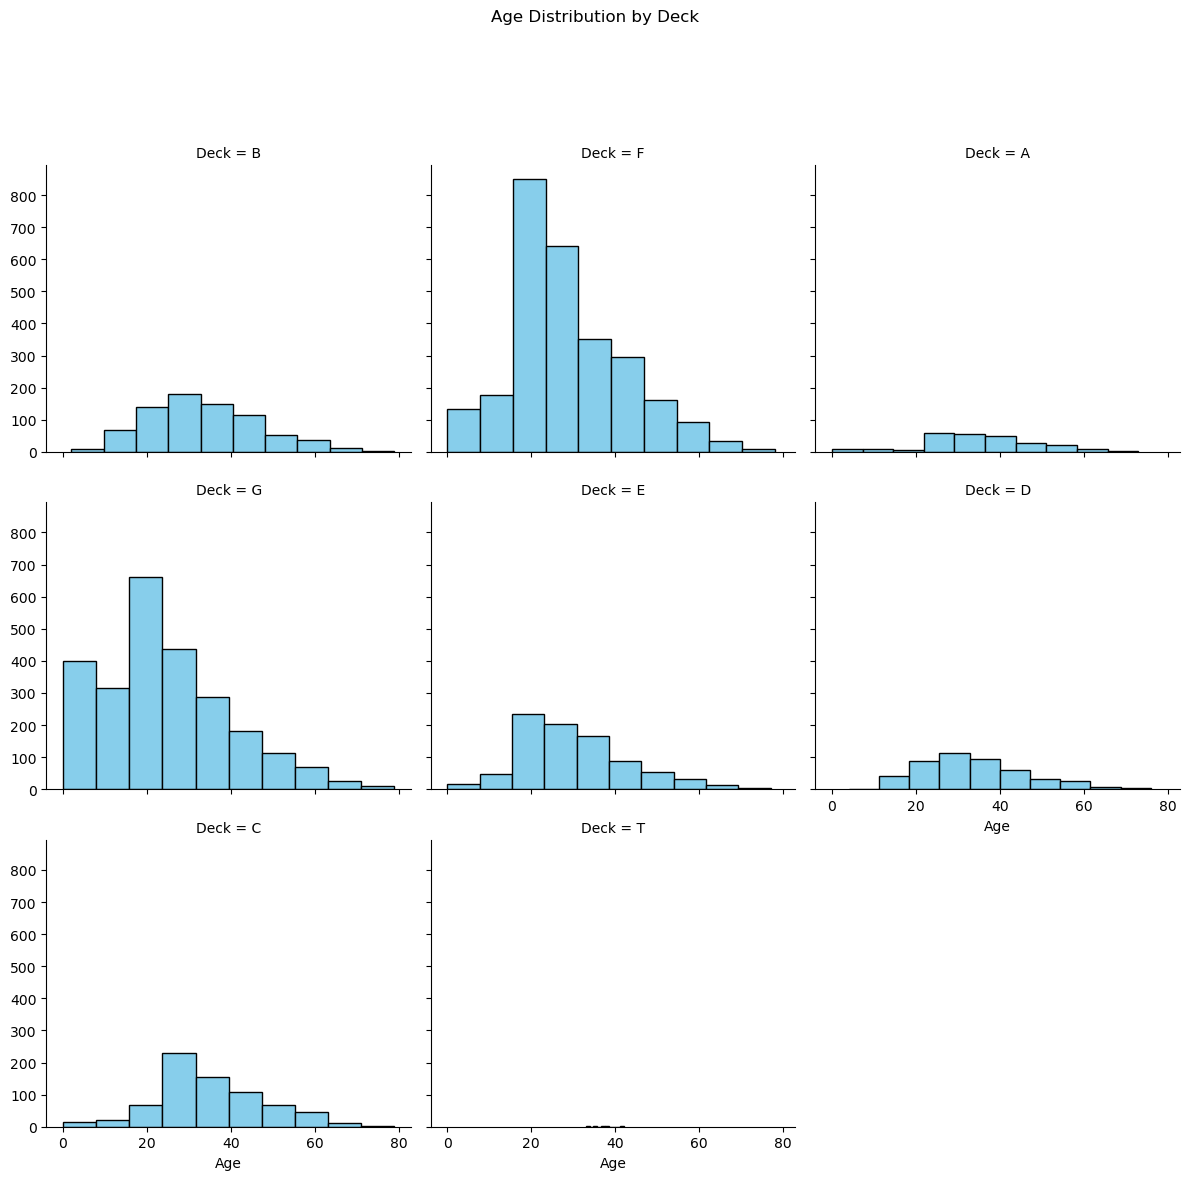

In [75]:
# Create a FacetGrid to plot the distribution of ages for each Deck
g = sns.FacetGrid(df_train, col='Deck', col_wrap=3, height=4, aspect=1)
g.map(plt.hist, 'Age', bins=10, color='skyblue', edgecolor='black')

# Add a title to the whole figure
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Age Distribution by Deck', x=0.5)

plt.show()

Key Observations:
1. Decks F and G have the highest populations
    - Both decks show a strong peak in the 20-30 age range.
    - The distribution is right-skewed, meaning younger travelers are more common.
    - Deck F has the highest overall count.
2. Decks B, C, D, and E have a more balanced age distribution
    - The peak ages still fall within the 20-40 range, but the spread is more even.
    - These decks seem to have fewer overall travelers compared to Decks F and G.
3. Deck A has very few travelers
    - The histogram suggests it is sparsely populated compared to the other decks.
4. Deck T has almost no representation
    - There is minimal data for this deck, indicating it may be an outlier or contain very few travelers.

Comparative Insights:
- Young adults (20-30 years old) dominate across most decks.
- Decks F and G are the most populated and attract younger travelers.
- Decks A and T have the fewest travelers, with very little age representation.
- Older individuals (50+ years old) are rare across all decks.

In [77]:
# Make a groupby dataframe with HomePlanet, Deck, Cryosleep
df_grouped = pd.DataFrame(df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep','Destination']).agg({'Age': ['median', 'mean']}))
df_grouped

Age           
                                               median       mean
HomePlanet GroupNumber CryoSleep Destination                    
Earth      01          False     55 Cancri e     24.0  26.535248
                                 PSO J318.5-22   25.0  29.726351
                                 TRAPPIST-1e     25.0  28.759250
                       True      55 Cancri e     23.0  25.148649
                                 PSO J318.5-22   23.0  25.895307
...                                               ...        ...
Mars       06          True      55 Cancri e     17.0  17.000000
                                 TRAPPIST-1e     14.0  14.000000
           07          False     55 Cancri e     24.0  24.000000
                                 TRAPPIST-1e     19.0  20.000000
                       True      TRAPPIST-1e     40.5  40.500000

[110 rows x 2 columns]

In [78]:
# Fill NaN values in 'Age' with the median age within each group defined by HomePlanet, Destination, and Deck
df_train['Age'] = df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep', 'Destination'])['Age'] \
                          .transform(lambda x: x.fillna(x.median()))

In [79]:
df_train['Age'].isnull().sum()

0

### Deck

In [81]:
df_train['Deck'].value_counts(dropna=False)

Deck
F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: count, dtype: int64

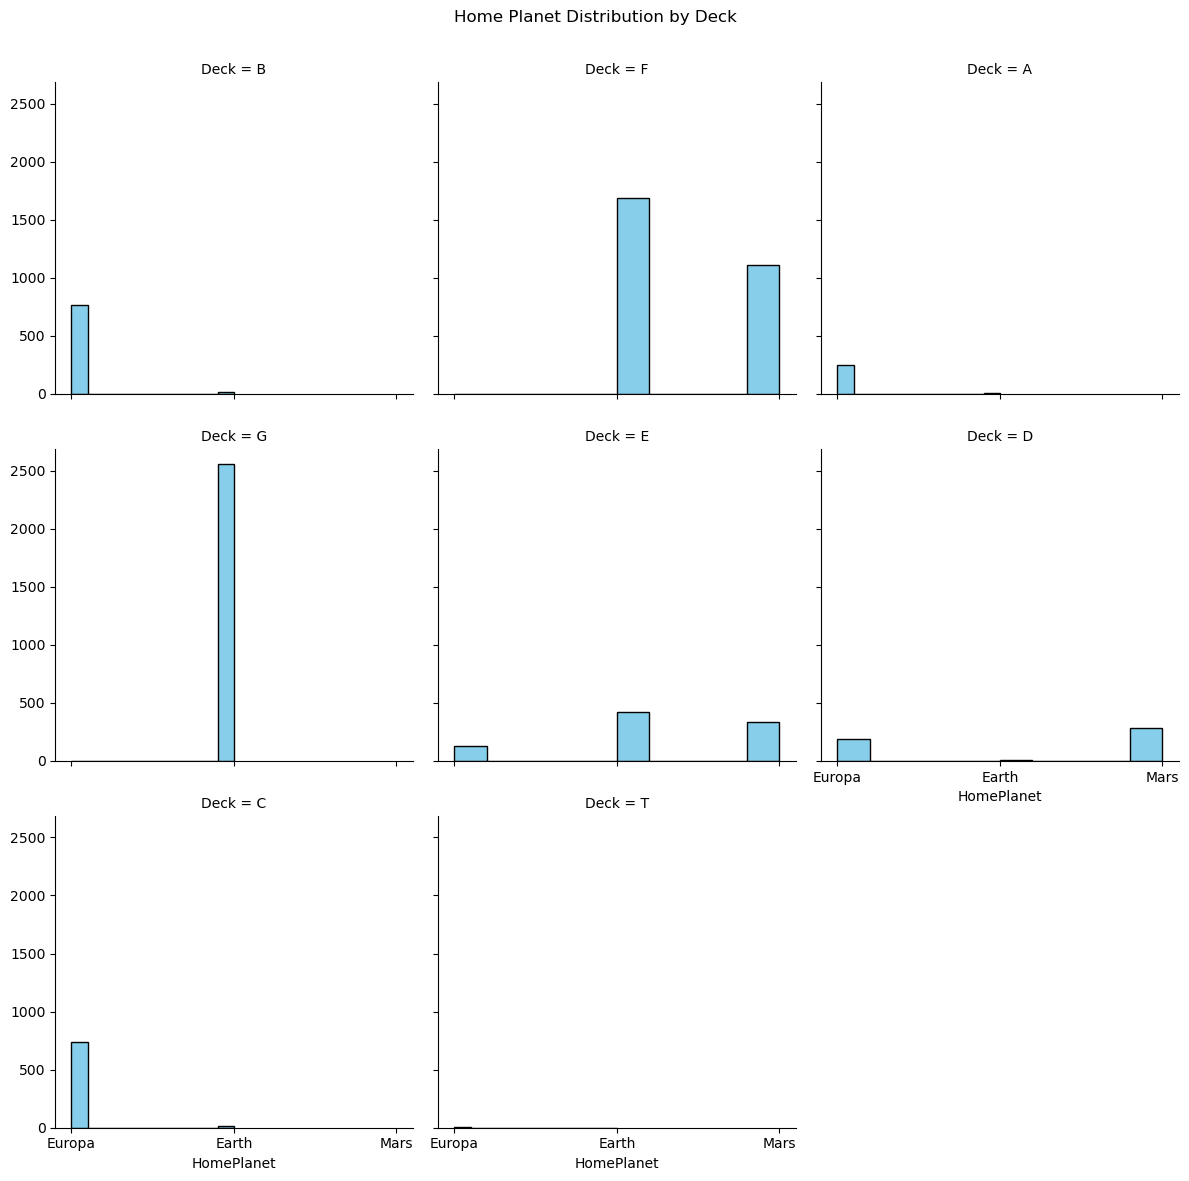

In [82]:
# Create a FacetGrid to plot the distribution of Home Planets for each Deck
g = sns.FacetGrid(df_train, col='Deck', col_wrap=3, height=4, aspect=1)
g.map(plt.hist, 'HomePlanet', bins=10, color='skyblue', edgecolor='black')

# Add a title to the whole figure
plt.subplots_adjust(top=.92)
g.fig.suptitle('Home Planet Distribution by Deck', x=0.5)

plt.show()

Key Observations:
1. Deck G is dominated by Earth travelers
    - There are almost no Europa or Mars travelers on this deck.
2. Deck F has a mix of Earth and Mars travelers
    - Both Earth and Mars contribute heavily to Deck F’s population.
    - There are more Mars travelers than Earth travelers, but the difference is not as extreme as in Deck G.
3. Decks B, C, D, and E have a balanced mix
    - These decks have a more even distribution of travelers from all three planets.
    - Europa travelers are slightly more common in some cases.
4. Deck A and T has very few travelers overall
    - The low count suggests that Deck A may not be a primary residence for most travelers.

Comparative Insights:
- Earth travelers dominate Deck G, with few from other planets.
- Deck F has the most diverse mix, with both Europa and Earth travelers.
- Mars travelers are present but much less common overall.
- Decks A and T are sparsely populated.

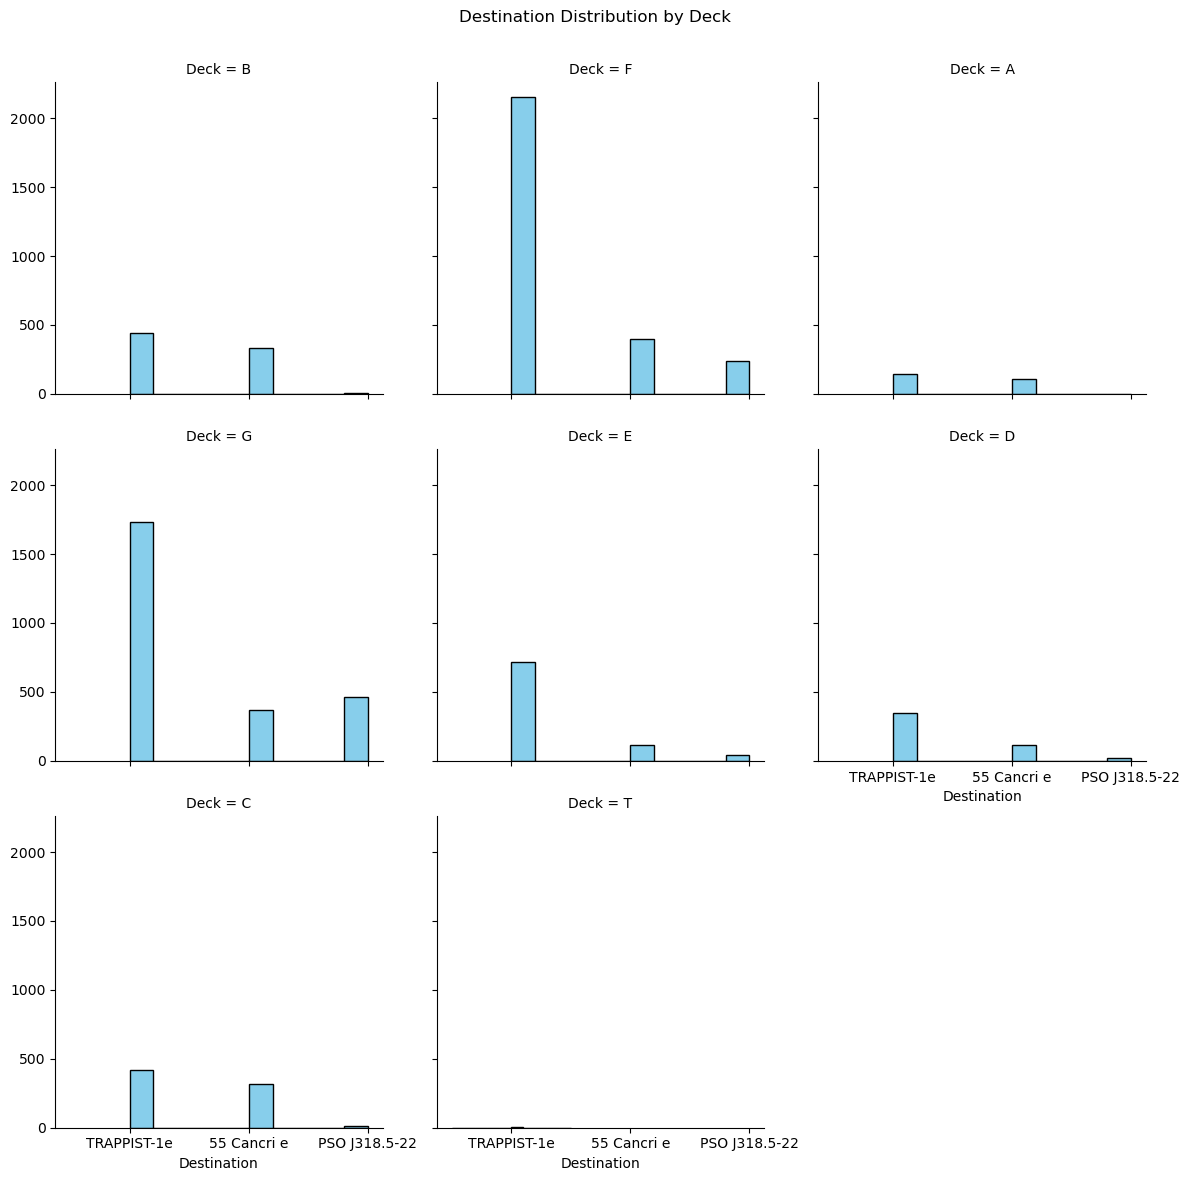

In [84]:
# Create a FacetGrid to plot the distribution of Destination and Decks
g = sns.FacetGrid(df_train, col='Deck', col_wrap=3, height=4, aspect=1)
g.map(plt.hist, 'Destination', bins=10, color='skyblue', edgecolor='black')

# Add a title to the whole figure
plt.subplots_adjust(top=.92)
g.fig.suptitle('Destination Distribution by Deck', x=0.5)

plt.show()

Key Observations:
1. TRAPPIST-1e is the most common destination across all decks
    - Decks F and G have the highest number of travelers going to TRAPPIST-1e.
    - Other decks also have a significant number of travelers headed there, but in smaller numbers.
2. 55 Cancri e has a moderate number of travelers
    - Present in all decks but in much smaller numbers compared to TRAPPIST-1e.
    - Decks E, B, and C show some travelers going to this destination.
3. PSO J318.5-22 has the fewest travelers
    - This destination appears the least across all decks.
    - Only a handful of travelers from each deck are headed there.
4. Deck A and Deck T have very few travelers overall
    - Both decks show very low traveler counts to any destination.
    - Deck T has almost no representation, similar to previous analyses.
      
Comparative Insights:
- TRAPPIST-1e is the dominant destination, especially for Decks F and G.
- 55 Cancri e is a secondary destination, with a small but noticeable traveler count across most decks.
- PSO J318.5-22 is the least popular destination overall.
- Decks F and G are the most populated and have the most travelers overall.
- Deck A and Deck T have minimal representation, suggesting they may not be main residential decks.

In [86]:
df_grouped = pd.DataFrame(df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep','Destination', 'Transported', 'Deck'])['Deck'].size())
df_grouped

Deck
HomePlanet GroupNumber CryoSleep Destination Transported Deck      
Earth      01          False     55 Cancri e False       A        1
                                                         E       13
                                                         F      160
                                                         G       67
                                             True        C        1
...                                                             ...
Mars       07          False     TRAPPIST-1e False       D        1
                                                         F        2
                                             True        D        1
                       True      TRAPPIST-1e False       E        1
                                             True        D        1

[459 rows x 1 columns]

In [87]:
# Fill the missing values with the Mode of the previous groupby
df_train['Deck'] = df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep','Destination', 'Transported'])['Deck'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

In [88]:
df_train['Deck'].value_counts(dropna=False)

Deck
F    2880
G    2610
E     877
B     812
C     775
D     478
A     256
T       5
Name: count, dtype: int64

### Side

In [90]:
# Check the value counts for the Side column
df_train['Side'].value_counts(dropna=False)

Side
S      4288
P      4206
NaN     199
Name: count, dtype: int64

In [91]:
# Groupby Home Planet, Group Number, Cryosleep, Destination, Transported, Deck, and Side
df_grouped = pd.DataFrame(df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep','Destination', 'Transported', 'Deck','Side'])['Side'].count())
df_grouped

Side
HomePlanet GroupNumber CryoSleep Destination Transported Deck Side      
Earth      01          False     55 Cancri e False       A    P        1
                                                         E    P        3
                                                              S       10
                                                         F    P       92
                                                              S       68
...                                                                  ...
Mars       07          False     TRAPPIST-1e False       F    P        1
                                                              S        1
                                             True        D    P        1
                       True      TRAPPIST-1e False       E    S        1
                                             True        D    S        1

[734 rows x 1 columns]

In [92]:
# Fill the missing values with the Mode of the previous groupby
df_train['Side'] = df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep','Destination', 'Transported', 'Deck'])['Side'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

### Cabin Number

In [94]:
# Get the value counts of the Cabin column
df_train['CabinNum'].value_counts(dropna=False)

CabinNum
NaN       199
82.0       28
86.0       22
19.0       22
56.0       21
         ... 
1644.0      1
1515.0      1
1639.0      1
1277.0      1
1894.0      1
Name: count, Length: 1818, dtype: int64

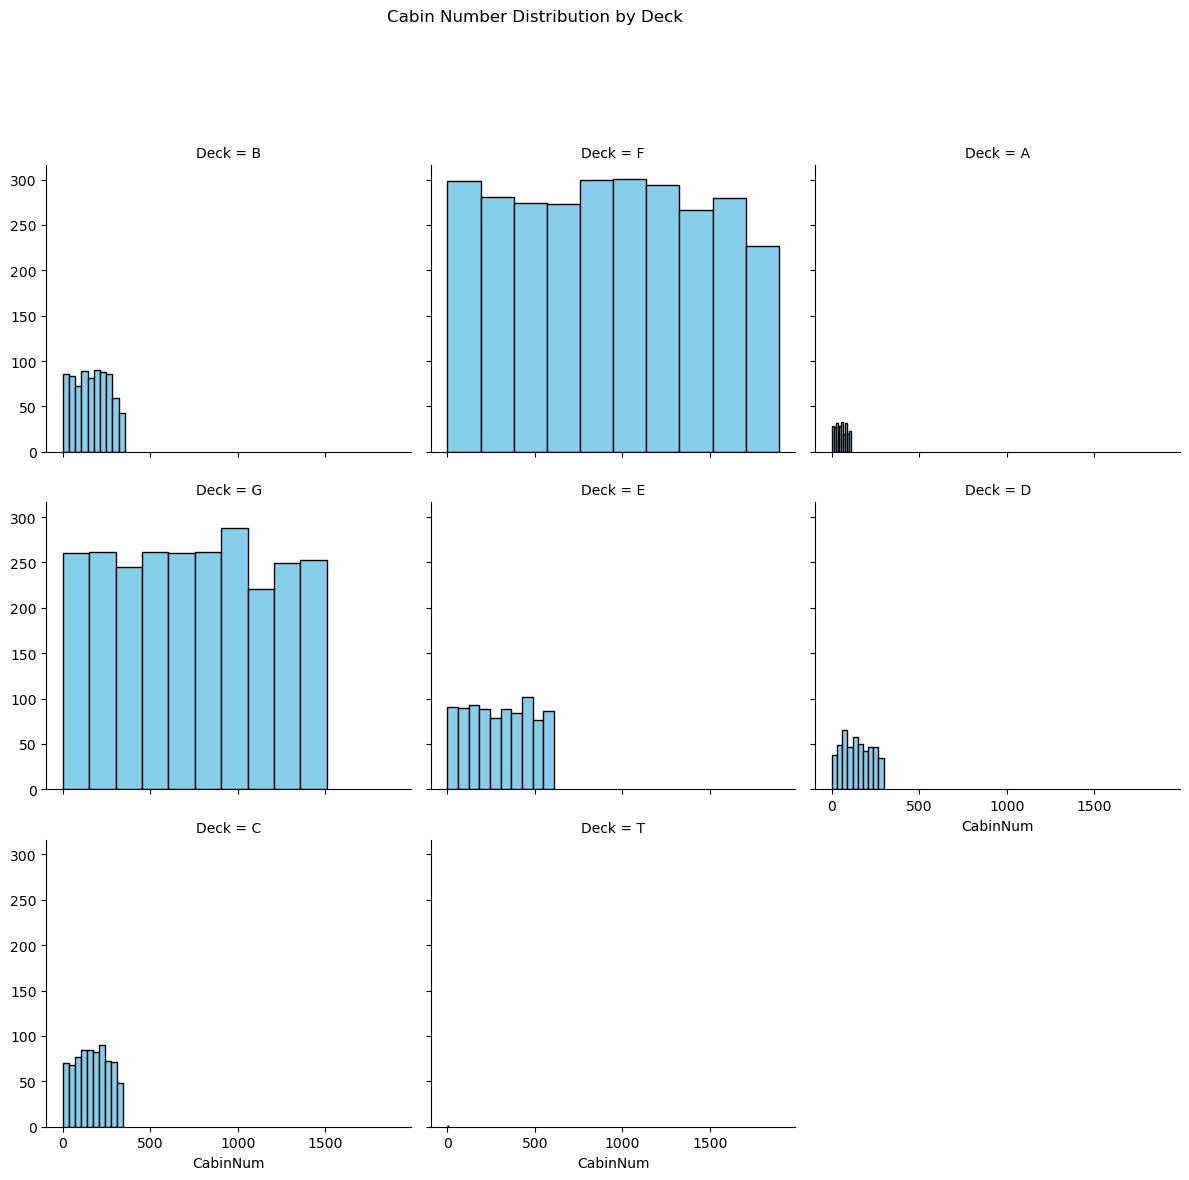

In [95]:
# Create a FacetGrid to plot the distribution of ages for each homeplanet
g = sns.FacetGrid(df_train, col='Deck', col_wrap=3, height=4, aspect=1)
g.map(plt.hist, 'CabinNum', bins=10, color='skyblue', edgecolor='black')

# Add a title to the whole figure
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Cabin Number Distribution by Deck', x=0.45)

plt.show()

This gives a really good idea into what cabin numbers are on what decks.

In [97]:
df_grouped = df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep', 'Destination', 
                               'Transported', 'Deck', 'Side', 'CabinNum']).agg({
    'CabinNum': ['median', 'mean', 'min', 'max']
})
df_grouped

CabinNum  \
                                                                              median   
HomePlanet GroupNumber CryoSleep Destination Transported Deck Side CabinNum            
Earth      01          False     55 Cancri e False       A    P    19.0         19.0   
                                                         E    P    8.0           8.0   
                                                                   60.0         60.0   
                                                                   401.0       401.0   
                                                              S    1.0           1.0   
...                                                                              ...   
Mars       07          False     TRAPPIST-1e False       F    P    448.0       448.0   
                                                              S    326.0       326.0   
                                             True        D    P    141.0       141.0   
                       True      TRAPPIST-1e False       E    S    13.0         13.0   
                                             True        D    S    176.0       176.0   

                                                                                    \
                                                                              mean   
HomePlanet GroupNumber CryoSleep Destination Transported Deck Side CabinNum          
Earth      01          False     55 Cancri e False       A    P    19.0       19.0   
                                                         E    P    8.0         8.0   
                                                                   60.0       60.0   
                                                                   401.0     401.0   
                                                              S    1.0         1.0   
...                                                                            ...   
Mars       07          False     TRAPPIST-1e False       F    P    448.0     448.0   
                                                              S    326.0     326.0   
                                             True        D    P    141.0     141.0   
                       True      TRAPPIST-1e False       E    S    13.0       13.0   
                                             True        D    S    176.0     176.0   

                                                                                    \
                                                                               min   
HomePlanet GroupNumber CryoSleep Destination Transported Deck Side CabinNum          
Earth      01          False     55 Cancri e False       A    P    19.0       19.0   
                                                         E    P    8.0         8.0   
                                                                   60.0       60.0   
                                                                   401.0     401.0   
                                                              S    1.0         1.0   
...                                                                            ...   
Mars       07          False     TRAPPIST-1e False       F    P    448.0     448.0   
                                                              S    326.0     326.0   
                                             True        D    P    141.0     141.0   
                       True      TRAPPIST-1e False       E    S    13.0       13.0   
                                             True        D    S    176.0     176.0   

                                                                                    
                                                                               max  
HomePlanet GroupNumber CryoSleep Destination Transported Deck Side CabinNum         
Earth      01          False     55 Cancri e False       A    P    19.0       19.0  
                                                         E    P    8.0         8.0  
        

In [98]:
# Fill the missing values with the Mode of the previous groupby
df_train['CabinNum'] = df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep', 'Destination','Transported', 'Deck', 'Side'])['CabinNum'] \
                          .transform(lambda x: x.fillna(x.median()))

In [99]:
df_train['CabinNum'].isnull().sum()

0

In [100]:
df_train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
PassengerID       0
GroupNumber       0
Deck              0
CabinNum          0
Side              0
dtype: int64

### VIP

In [102]:
df_train['VIP'].value_counts(dropna=False)

VIP
False    8291
NaN       203
True      199
Name: count, dtype: int64

In [103]:
# If the NaN value has True in the Cryosleep column then fill it with False
df_train.loc[(df_train['CryoSleep'] == True) & (df_train['VIP'].isna()), 'VIP'] = False

In [104]:
# Fill the missing values with the Mode of the groupby
df_train['VIP'] = df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep','Destination', 'Transported', 'Deck'])['VIP'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

In [105]:
df_train['VIP'].value_counts(dropna=False)

VIP
False    8494
True      199
Name: count, dtype: int64

### Room Service

In [107]:
df_train['RoomService'].value_counts(dropna=False)

RoomService
0.0       5577
NaN        181
1.0        117
2.0         79
3.0         61
          ... 
1612.0       1
2598.0       1
632.0        1
378.0        1
745.0        1
Name: count, Length: 1274, dtype: int64

In [108]:
df_train.loc[(df_train['CryoSleep'] == True) & (df_train['RoomService'].isna()), 'RoomService'] = 0

In [109]:
# Fill the missing values with the Mode of the previous groupby
df_train['RoomService'] = df_train.groupby(['HomePlanet', 'GroupNumber', 'Destination','Transported', 'Deck', 'Side'])['RoomService'] \
                          .transform(lambda x: x.fillna(x.median()))

In [110]:
df_train['RoomService'].isnull().sum()

0

### Food Court

In [112]:
df_train['FoodCourt'].value_counts(dropna=False)

FoodCourt
0.0       5456
NaN        183
1.0        116
2.0         75
3.0         53
          ... 
3846.0       1
5193.0       1
312.0        1
827.0        1
4688.0       1
Name: count, Length: 1508, dtype: int64

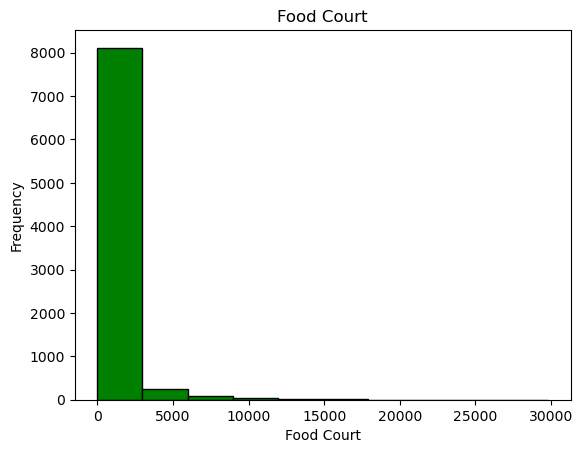

In [113]:
# Plot a histogram of the 'Room Service' column
plt.hist(df_train['FoodCourt'], bins=10, color='green', edgecolor='black')

# Title and labels
plt.title('Food Court')
plt.xlabel('Food Court')
plt.ylabel('Frequency')

plt.show()

In [114]:
# If the person is in Cryo Sleep then they aren't spending any $. Therefore
# fill the missing value with 0.0 if the person is in Cryo Sleep
df_train.loc[(df_train['CryoSleep'] == True) & (df_train['FoodCourt'].isna()), 'FoodCourt'] = 0

In [115]:
# Fill the missing values with the Mode of the groupby
df_train['FoodCourt'] = df_train.groupby(['HomePlanet', 'GroupNumber','Transported', 'Deck', 'Side'])['FoodCourt'] \
                          .transform(lambda x: x.fillna(x.median()))

In [116]:
# Check for remaining null values
df_train['FoodCourt'].isnull().sum()

2

In [117]:
# Fill remaining with zero, the mode
df_train['FoodCourt'] = df_train['FoodCourt'].fillna(0.0)

### Shopping Mall

In [119]:
# Check the value counts of the Shopping Mall column
df_train['ShoppingMall'].value_counts(dropna=False)

ShoppingMall
0.0       5587
NaN        208
1.0        153
2.0         80
3.0         59
          ... 
3627.0       1
2074.0       1
871.0        1
742.0        1
1872.0       1
Name: count, Length: 1116, dtype: int64

In [120]:
# If the person is in Cryo Sleep then they aren't spending any $. Therefore
# fill the missing value with 0.0 if the person is in Cryo Sleep
df_train.loc[(df_train['CryoSleep'] == True) & (df_train['ShoppingMall'].isna()), 'ShoppingMall'] = 0

In [121]:
# Fill the missing values with the Mode
df_train['ShoppingMall'] = df_train.groupby(['HomePlanet', 'GroupNumber', 'Deck', 'Side'])['CabinNum'] \
                          .transform(lambda x: x.fillna(x.median()))

In [122]:
# Check for any remaining null values 
df_train['ShoppingMall'].isnull().sum()

0

### SPA

In [124]:
df_train['Spa'].value_counts(dropna=False)

Spa
0.0       5324
NaN        183
1.0        146
2.0        105
3.0         53
          ... 
273.0        1
2581.0       1
2948.0       1
3778.0       1
1643.0       1
Name: count, Length: 1328, dtype: int64

In [125]:
# Fill the missing values based on the Cryosleep column. If its True then Spa NaN value is 0
df_train.loc[(df_train['CryoSleep'] == True) & (df_train['Spa'].isna()), 'Spa'] = 0

In [126]:
# Fill the missing values with the Median groupby
df_train['Spa'] = df_train.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep', 'Destination','Transported', 'Deck', 'Side'])['Spa'] \
                          .transform(lambda x: x.fillna(x.median()))

In [127]:
# Check for any remaining null values
df_train['Spa'].isnull().sum()

4

In [128]:
# Fill remaining values with 0.0, the mode
df_train['Spa'] = df_train['Spa'].fillna(0.0)

### VR Deck

In [130]:
# Check the value counts of the VR Deck column
df_train['VRDeck'].value_counts(dropna=False)

VRDeck
0.0       5495
NaN        188
1.0        139
2.0         70
3.0         56
          ... 
297.0        1
1788.0       1
1113.0       1
9244.0       1
3235.0       1
Name: count, Length: 1307, dtype: int64

In [131]:
# If the person is in Cryo Sleep then they aren't spending any $. Therefore
# fill the missing value with 0.0 if the person is in Cryo Sleep
df_train.loc[(df_train['CryoSleep'] == True) & (df_train['VRDeck'].isna()), 'VRDeck'] = 0

In [132]:
# Check the column for any remaining null values
df_train['VRDeck'].isnull().sum()

126

In [133]:
# Fill the missing values with the Mode of the Groupby Home Planet, Group Number, Deck and Side
df_train['VRDeck'] = df_train.groupby(['HomePlanet', 'GroupNumber', 'Deck', 'Side'])['VRDeck'] \
                          .transform(lambda x: x.fillna(x.median()))

In [134]:
# Check for remaining null values
df_train['VRDeck'].isnull().sum()

1

In [135]:
# Fill the last NaN value with the Mode 0.0
df_train['VRDeck'] = df_train['VRDeck'].fillna(0.0)

### Name

In [137]:
# Drop the Name column
df_train.drop(columns='Name', inplace=True)

In [138]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Transported   8693 non-null   bool   
 12  PassengerID   8693 non-null   object 
 13  GroupNumber   8693 non-null   object 
 14  Deck          8693 non-null   object 
 15  CabinNum      8693 non-null   float64
 16  Side          8693 non-null   object 
dtypes: bool(3), float64(7), object(7)
memory usage: 976.4+ KB


In [139]:
# Final check of NaN values
df_train.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
PassengerID     0
GroupNumber     0
Deck            0
CabinNum        0
Side            0
dtype: int64

## Outliers

Make a boxplot of all numerical columns so we can see if there are any outliers that we need to look at and address.

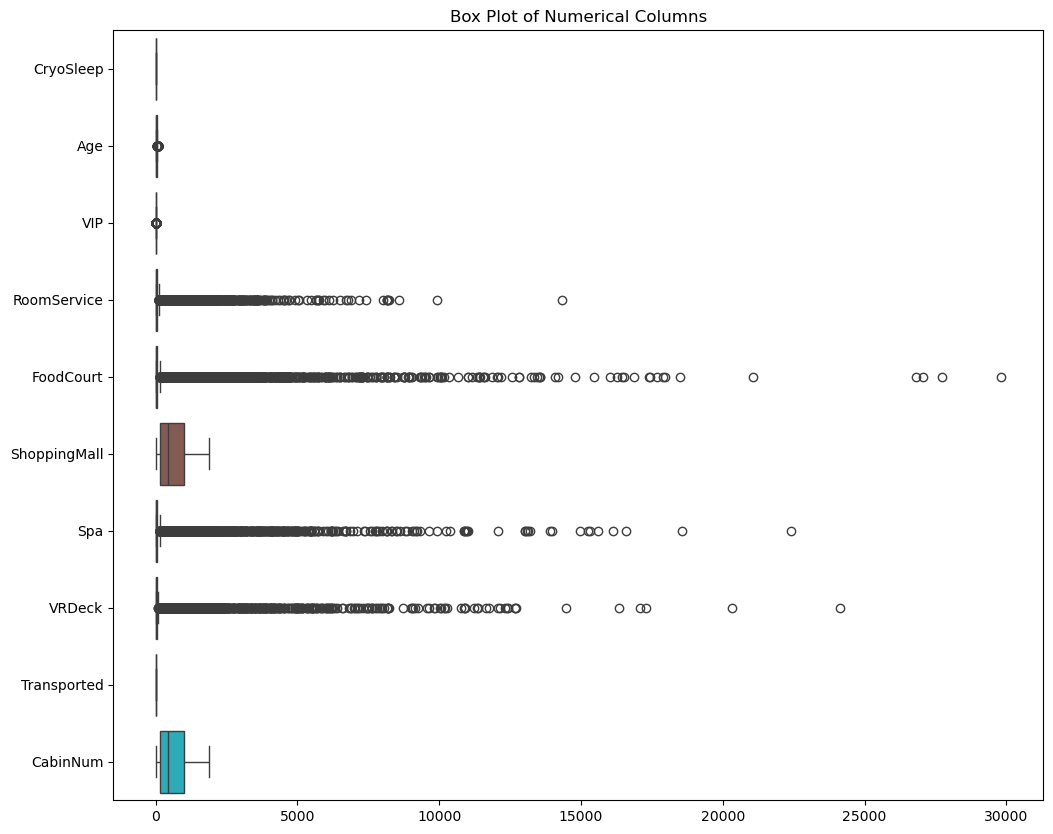

In [142]:
# Make a boxplot of all numerical features
plt.figure(figsize=(12, 10))
sns.boxplot(data=df_train, orient="h")  # Horizontal box plot for better readability
plt.title('Box Plot of Numerical Columns')
plt.show()

1. Columns with Extreme Outliers:
- RoomService, FoodCourt, Spa, VRDeck:
    - These columns exhibit extreme outliers with values exceeding 25,000–30,000.
    - Most values are clustered around zero, with a large number of data points having very low values.
    - This suggests many individuals spent nothing on these services.
2. Columns with Moderate Distribution:
    - Age:
        - The distribution is more balanced, with a few outliers on the higher end.
        - Most passengers fall within a reasonable age range.
    - CabinNum:
        - The data appears to have a relatively normal distribution.
3. Notable Patterns:
- Spending-related features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) have highly skewed distributions.
- Age, Shopping Mall and CabinNum appear more normally distributed.  
4. Possible Data Cleaning Considerations:
- Handling Outliers: Many columns have extreme values that could be capped, transformed, or analyzed separately.
- Feature Scaling: Due to the large range in some columns, normalization or log transformation might improve modeling.

### Age

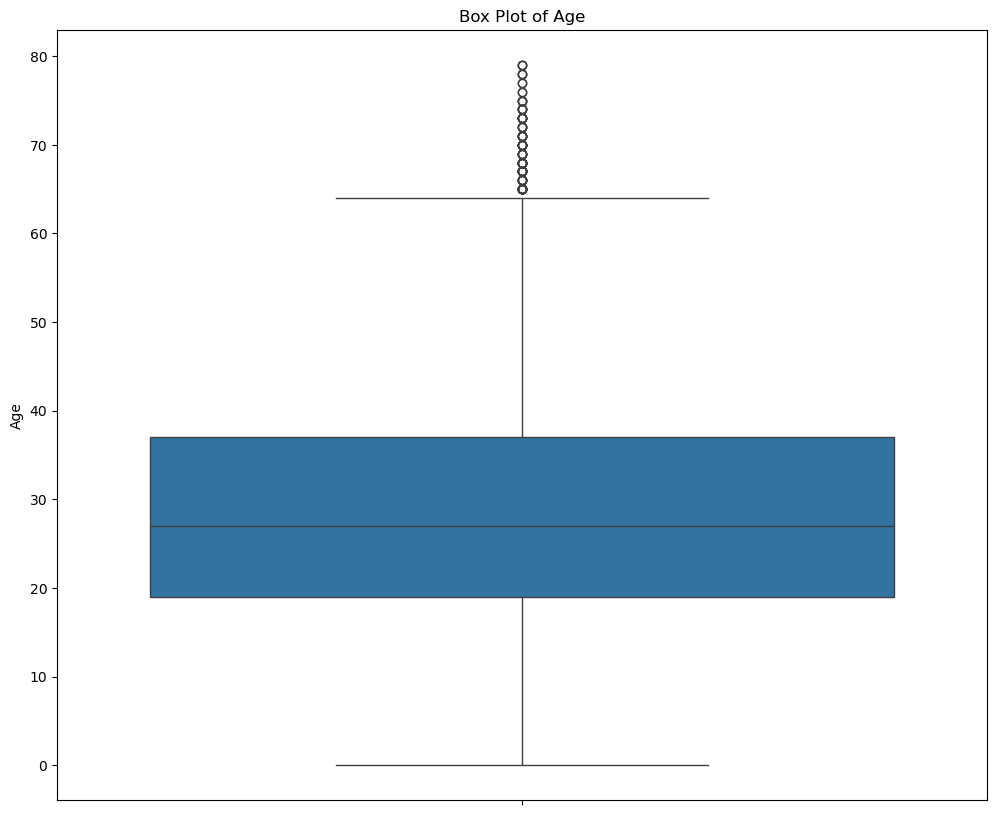

In [145]:
# Make a boxplot of Age
plt.figure(figsize=(12, 10))
sns.boxplot(data=df_train['Age'])  # Horizontal box plot for better readability
plt.title('Box Plot of Age')
plt.show()

In [146]:
# Look at the rows where the Age is above 62
# Define the threshold
threshold = 63

# Filter rows where age is above the threshold
filtered_df = df_train[df_train['Age'] > threshold]
filtered_df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerID,GroupNumber,Deck,CabinNum,Side
109,0113_01,Earth,False,TRAPPIST-1e,64.0,False,0.0,0.0,23.0,0.0,0.0,True,0113,01,F,23.0,P
118,0126_01,Mars,True,TRAPPIST-1e,67.0,False,0.0,0.0,27.0,0.0,0.0,True,0126,01,F,27.0,S
280,0310_01,Europa,False,TRAPPIST-1e,67.0,False,0.0,230.0,169.0,4476.0,241.0,False,0310,01,C,169.0,P
338,0378_03,Europa,False,TRAPPIST-1e,79.0,False,5649.0,235.0,11.0,2579.0,2175.0,False,0378,03,B,11.0,S
378,0417_01,Europa,True,55 Cancri e,68.0,False,0.0,0.0,18.0,0.0,0.0,True,0417,01,B,18.0,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8254,8816_05,Europa,False,TRAPPIST-1e,64.0,False,0.0,1770.0,340.0,4111.0,180.0,False,8816,05,B,340.0,S
8288,8852_01,Mars,True,TRAPPIST-1e,76.0,False,0.0,0.0,278.0,0.0,0.0,True,8852,01,D,278.0,P
8369,8954_01,Earth,False,PSO J318.5-22,73.0,False,1806.0,0.0,1452.0,0.0,0.0,False,8954,01,G,1452.0,P
8516,9085_01,Europa,False,55 Cancri e,70.0,False,0.0,2113.0,95.0,1972.0,51.0,False,9085,01,A,95.0,P


This isn't really out of the ordinary. I'm not going to modify this column in any way. 

### Room Service

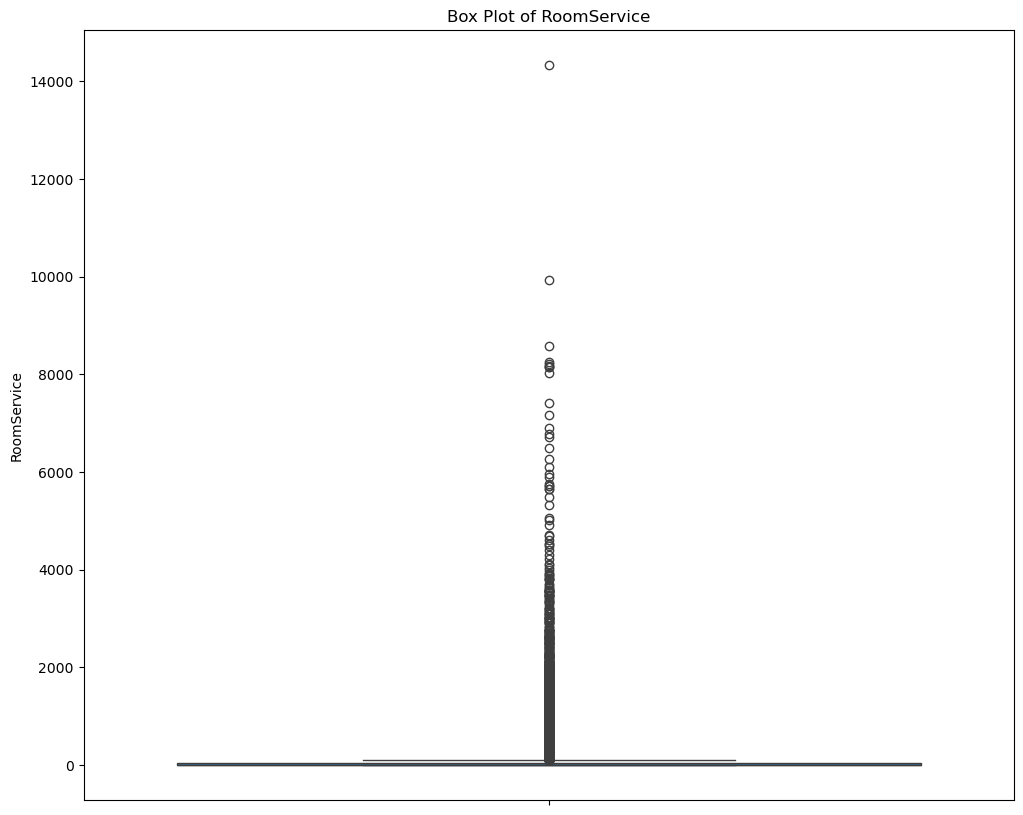

In [149]:
# Make a boxplot of Age
plt.figure(figsize=(12, 10))
sns.boxplot(data=df_train['RoomService'])  # Horizontal box plot for better readability
plt.title('Box Plot of RoomService')
plt.show()

**Key Observations**
- Majority of values are near zero:
    - The box plot indicates that most of the data points are concentrated near the lower range (close to 0).
    - This suggests that many individuals either did not use room service or spent very little.
- Presence of outliers:
    - A large number of individual points are plotted above the main distribution, indicating many high-value outliers.
    - Some individuals spent several thousand units on room service, which is far above the bulk of the data.
- Narrow interquartile range (IQR):  
    - The central box (which represents the middle 50% of the data) appears to be very compressed near the bottom.
    - This confirms that most people spent little to nothing on room service.

**Key Takeaways**
- The majority of individuals spent very little or nothing on room service.
- A small number of individuals spent an exceptionally high amount, resulting in many outliers.
- The distribution is highly skewed, with extreme values significantly impacting the spread.

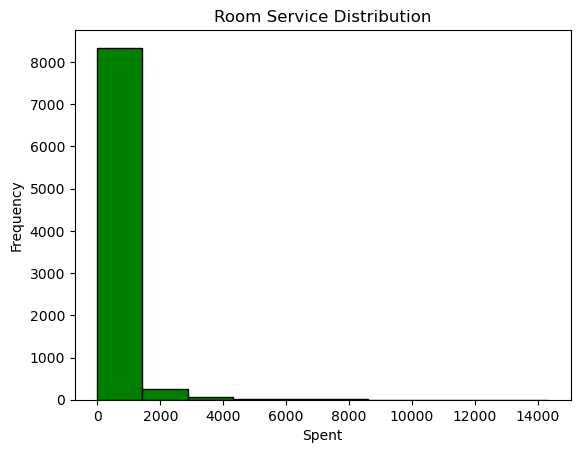

In [150]:
# Plot a histogram of the 'Room Service' column
plt.hist(df_train['RoomService'], bins=10, color='green', edgecolor='black')

# Title and labels
plt.title('Room Service Distribution')
plt.xlabel('Spent')
plt.ylabel('Frequency')

plt.show()

There are just a few outliers that I'll bring back down to 8000 as the cap for spending.

In [152]:
# Define the threshold
threshold = 8000
new_value = 8000  # Value to replace Room Service above the threshold

# Modify values in the 'Room Service' column
df_train.loc[df_train['RoomService'] > threshold, 'RoomService'] = new_value

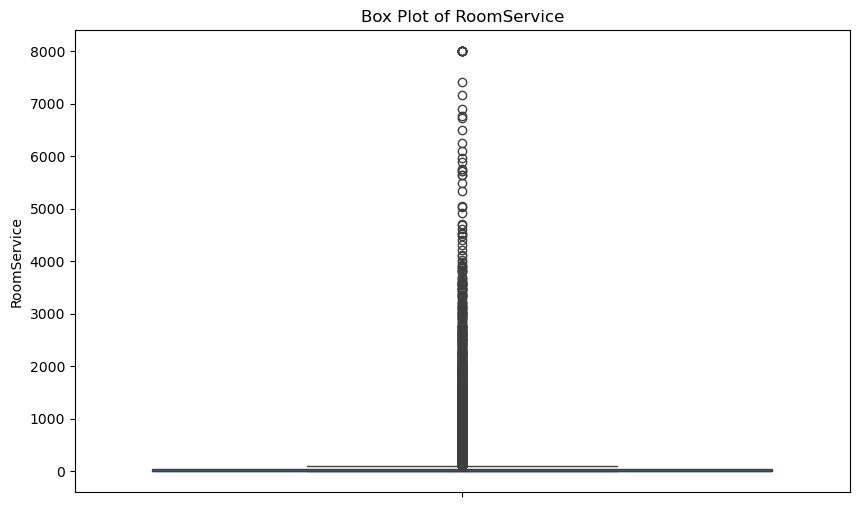

In [153]:
# Check the changes with a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train['RoomService'])  # Horizontal box plot for better readability
plt.title('Box Plot of RoomService')
plt.show()

### Food Court

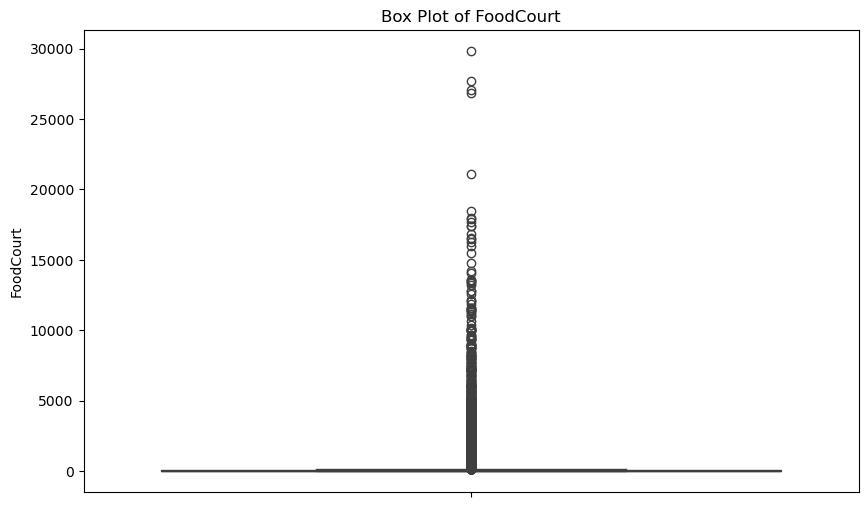

In [155]:
# Boxplot of Food Court
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train['FoodCourt']) 
plt.title('Box Plot of FoodCourt')
plt.show()

I'll take everything above 20000 and make it 20000.

In [157]:
# Define the threshold
threshold = 20000
new_value = 20000 # Value to replace values above the threshold

# Modify values in the 'Food Court' column
df_train.loc[df_train['FoodCourt'] > threshold, 'FoodCourt'] = new_value

In [158]:
# Check the changes in Food Court
df_train['FoodCourt'].max()

20000.0

### Spa

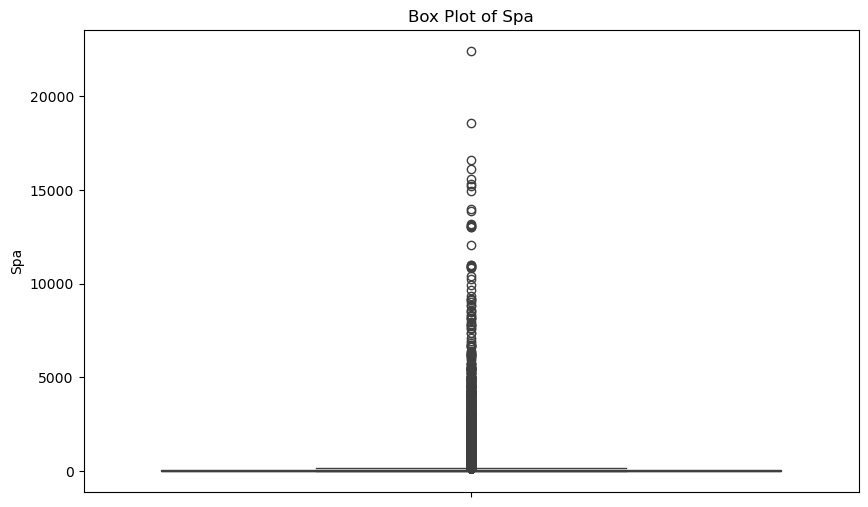

In [160]:
# Boxplot of Spa
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train['Spa']) 
plt.title('Box Plot of Spa')
plt.show()

In [161]:
# Define the threshold
threshold = 15000
new_value = 15000 # Value to replace above the threshold

# Modify values in the 'Spa' column
df_train.loc[df_train['Spa'] > threshold, 'Spa'] = new_value

In [162]:
# Check for the max value to clarify changes
df_train['Spa'].max()

15000.0

### VRDeck

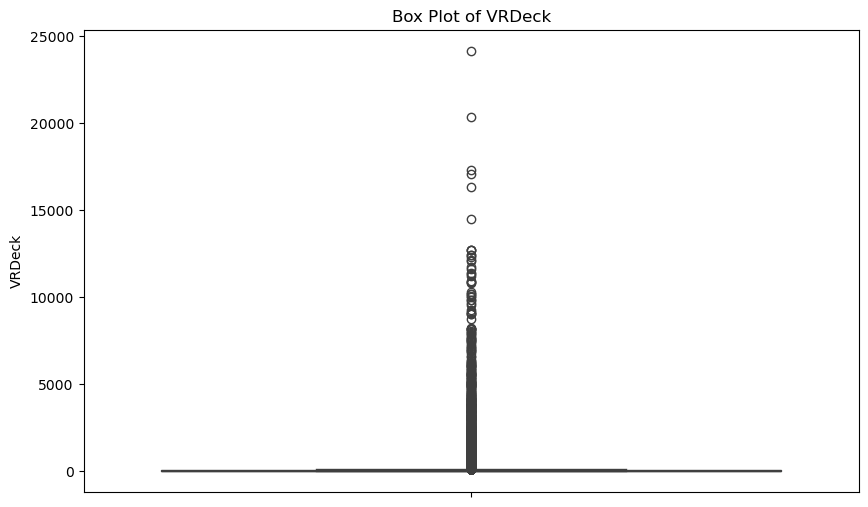

In [164]:
# Boxplot of VR Deck
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train['VRDeck']) 
plt.title('Box Plot of VRDeck')
plt.show()

In [165]:
# Define the threshold
threshold = 14000
new_value = 14000 # Value to replace above the threshold

# Modify values in the 'Spa' column
df_train.loc[df_train['VRDeck'] > threshold, 'VRDeck'] = new_value

In [166]:
# Check for max value to clarify changes
df_train['VRDeck'].max()

14000.0

## Dummy Variables

In [168]:
# List categorical columns
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['PassengerId',
 'HomePlanet',
 'Destination',
 'PassengerID',
 'GroupNumber',
 'Deck',
 'Side']

### Passenger ID

In [170]:
# Drop both Passenger ID columns
df_train.drop(columns='PassengerId', inplace=True)
df_train.drop(columns='PassengerID', inplace=True)

### Home Planet

In [172]:
# Create dummy variables
df_train = pd.get_dummies(df_train, columns=['HomePlanet'], drop_first=False)

In [173]:
# Convert the dummy variables to numerical
df_train['HomePlanet_Earth'] = df_train['HomePlanet_Earth'].astype(int)
df_train['HomePlanet_Europa'] = df_train['HomePlanet_Europa'].astype(int)
df_train['HomePlanet_Mars'] = df_train['HomePlanet_Mars'].astype(int)

### Destination

In [175]:
# Create dummy variables
df_train = pd.get_dummies(df_train, columns=['Destination'], drop_first=False)

In [176]:
# Convert the dummy variables to numerical
df_train['Destination_55 Cancri e'] = df_train['Destination_55 Cancri e'].astype(int)
df_train['Destination_PSO J318.5-22'] = df_train['Destination_PSO J318.5-22'].astype(int)
df_train['Destination_TRAPPIST-1e'] = df_train['Destination_TRAPPIST-1e'].astype(int)

### Group Number

In [178]:
# Convert GroupNumber column to numerical
df_train['GroupNumber'] = df_train['GroupNumber'].astype(int)

### Deck

In [180]:
# Create dummy variables
df_train = pd.get_dummies(df_train, columns=['Deck'], drop_first=False)

In [181]:
# Convert the columns to numerical
df_train['Deck_A'] = df_train['Deck_A'].astype(int)
df_train['Deck_B'] = df_train['Deck_B'].astype(int)
df_train['Deck_C'] = df_train['Deck_C'].astype(int)
df_train['Deck_D'] = df_train['Deck_D'].astype(int)
df_train['Deck_E'] = df_train['Deck_E'].astype(int)
df_train['Deck_F'] = df_train['Deck_F'].astype(int)
df_train['Deck_G'] = df_train['Deck_G'].astype(int)
df_train['Deck_T'] = df_train['Deck_T'].astype(int)

### Side

In [183]:
# Create dummy variables
df_train = pd.get_dummies(df_train, columns=['Side'], drop_first=False)

In [184]:
# Convert the columns to numerical
df_train['Side_P'] = df_train['Side_P'].astype(int)
df_train['Side_S'] = df_train['Side_S'].astype(int)

### Cryo Sleep, VIP, Transported

In [186]:
# Convert the columns to numerical
df_train['CryoSleep'] = df_train['CryoSleep'].astype(int)
df_train['VIP'] = df_train['VIP'].astype(int)
df_train['Transported'] = df_train['Transported'].astype(int)

In [187]:
# Check the dataframe
df_train.head().T

,0,1,2,3,4
CryoSleep,0.0,0.0,0.0,0.0,0.0
Age,39.0,24.0,58.0,33.0,16.0
VIP,0.0,0.0,1.0,0.0,0.0
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,0.0,0.0,0.0,1.0
Spa,0.0,549.0,6715.0,3329.0,565.0
VRDeck,0.0,44.0,49.0,193.0,2.0
Transported,0.0,1.0,0.0,0.0,1.0
GroupNumber,1.0,1.0,1.0,2.0,1.0


In [188]:
df_train_processed = df_train

## Correlation Matrix and Heatmap

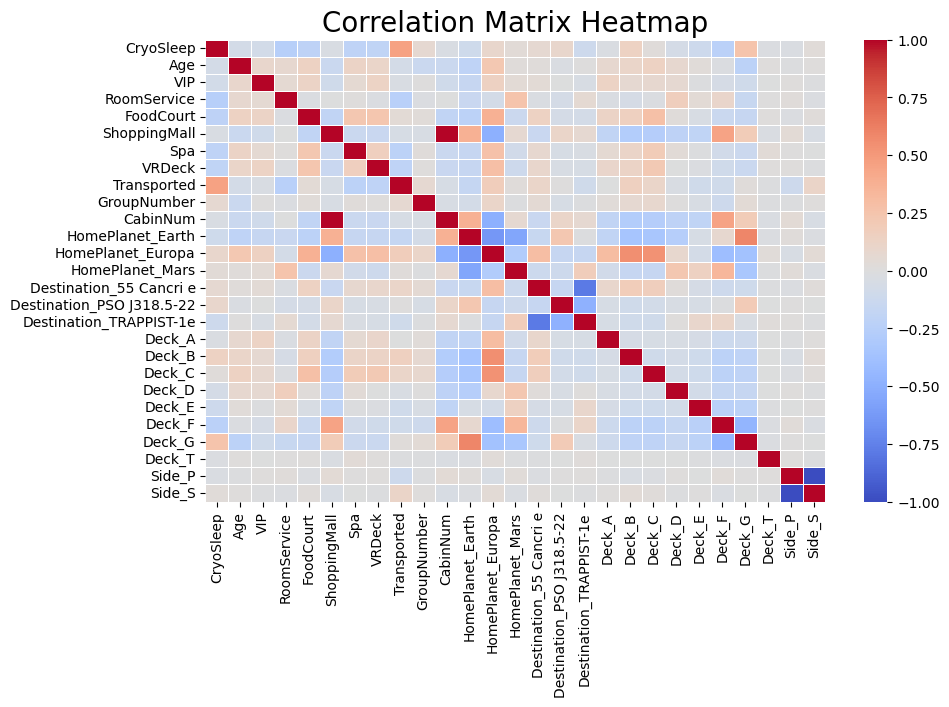

In [190]:
# Compute the correlation matrix
corr_matrix = df_train.corr()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix Heatmap", fontsize=20)
plt.show()

**Key Observations**
1. CryoSleep Correlation:  
    - Strong positive correlation with Transported, suggesting that individuals in cryo sleep were more likely to be transported.
    - Negative correlation with RoomService, FoodCourt, and ShoppingMall, indicating that those in cryo sleep spent less in these areas.
2. RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck:  
    - These spending categories show some positive correlations with each other, suggesting that individuals who spent in one category were likely to spend in others.
3. HomePlanet Variables:  
    - The variables representing different home planets (Earth, Europa, Mars) show negative correlations with each other, which is expected as they are mutually exclusive categories.
4. Destination Variables:  
    - Different destination categories (55 Cancri e, PSO J318.5-22, TRAPPIST-1e) also show negative correlations with one another, as an individual can only have one destination.
5. Deck Variables:
    - Some decks (A, B, C, etc.) show moderate correlations with certain variables, potentially indicating patterns in accommodation preferences.
6. Side_P and Side_S:
    - These two sides are perfectly negatively correlated (-1) since they are binary (if someone is on Side_P, they cannot be on Side_S).


**Key Takeaways**
- CryoSleep is a strong predictor of Transported status.
- Spending categories are correlated with each other, indicating general spending behavior.
- HomePlanet and Destination variables are negatively correlated among themselves due to mutual exclusivity.
- Decks and cabin-related variables may influence transport likelihood and spending habits.

In [191]:
# Get absolute correlations, unstack, and sort
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_pairs = corr_pairs[corr_pairs['Feature 1'] != corr_pairs['Feature 2']]  # Remove self-correlations
corr_pairs['Correlation'] = corr_pairs['Correlation'].round(2)  # Round values

# Remove duplicate pairs (since correlation matrix is symmetric)
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'], keep='first')

# Get top 10 correlations (both positive and negative)
top_corr = corr_pairs.sort_values(by='Correlation', ascending=False).head(10)
bottom_corr = corr_pairs.sort_values(by='Correlation', ascending=True).head(10)

In [192]:
top_corr

,Feature 1,Feature 2,Correlation
145,ShoppingMall,CabinNum,1.00
320,HomePlanet_Earth,Deck_G,0.59
342,HomePlanet_Europa,Deck_B,0.55
343,HomePlanet_Europa,Deck_C,0.54
8,CryoSleep,Transported,0.46
157,ShoppingMall,Deck_F,0.45
120,FoodCourt,HomePlanet_Europa,0.37
373,HomePlanet_Mars,Deck_F,0.34
341,HomePlanet_Europa,Deck_A,0.30
201,VRDeck,HomePlanet_Europa,0.29


In [193]:
bottom_corr

,Feature 1,Feature 2,Correlation
701,Side_P,Side_S,-1.00
394,Destination_55 Cancri e,Destination_TRAPPIST-1e,-0.78
309,HomePlanet_Earth,HomePlanet_Europa,-0.63
310,HomePlanet_Earth,HomePlanet_Mars,-0.56
147,ShoppingMall,HomePlanet_Europa,-0.49
617,Deck_F,Deck_G,-0.46
346,HomePlanet_Europa,Deck_F,-0.40
347,HomePlanet_Europa,Deck_G,-0.37
315,HomePlanet_Earth,Deck_B,-0.35
316,HomePlanet_Earth,Deck_C,-0.34


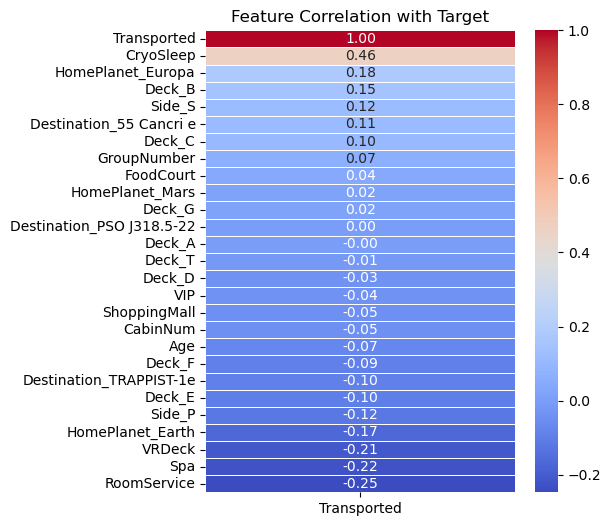

In [194]:
# Compute correlation of all features with the target
target_corr = df_train.corr()[['Transported']].sort_values(by='Transported', ascending=False)

# Plot heatmap
plt.figure(figsize=(5, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# Title
plt.title("Feature Correlation with Target", fontsize=12)

# Show plot
plt.show()

# Train, Test, Split

In [196]:
from sklearn.model_selection import train_test_split

In [197]:
X = df_train.drop('Transported', axis=1) # Features
y = df_train['Transported'].astype(int) # Target

In [198]:
X.shape

(8693, 26)

In [199]:
y.shape

(8693,)

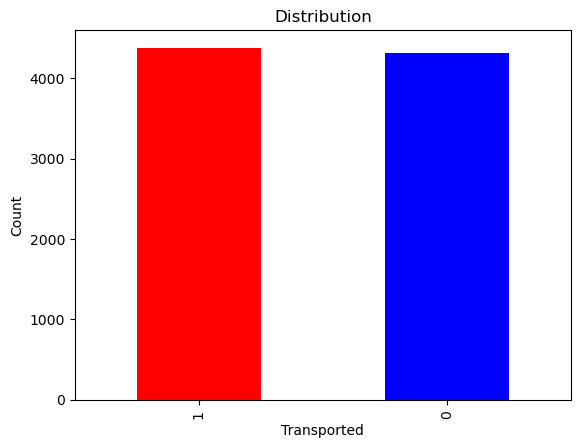

In [200]:
# Plot of Transported
df_train['Transported'].value_counts().plot(kind='bar', color=['red', 'blue'])

# Labels and title
plt.xlabel('Transported')
plt.ylabel('Count')
plt.title('Distribution')

# Show plot
plt.show()

Here, we can see that the target variable transported is evenly distributed, so we won't have to deal with an unbalanced dataset. 

In [202]:
# Split the data into training and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

## Scaling the Data

In [204]:
from sklearn.preprocessing import StandardScaler

In [205]:
scaler = StandardScaler()

In [206]:
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Deep Learning Model

In [208]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define Input layer explicitly

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5777 - loss: 0.7686 - val_accuracy: 0.7113 - val_loss: 0.5592
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7114 - loss: 0.5625 - val_accuracy: 0.7657 - val_loss: 0.4845
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7410 - loss: 0.5241 - val_accuracy: 0.7729 - val_loss: 0.4563
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7555 - loss: 0.4927 - val_accuracy: 0.7832 - val_loss: 0.4451
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7642 - loss: 0.4727 - val_accuracy: 0.7855 - val_loss: 0.4350
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7820 - loss: 0.4559 - val_accuracy: 0.7838 - val_loss: 0.4327
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7945 - loss: 0.4400 - val_accuracy: 0.7884 - val_loss: 0.4280
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7864 - loss: 0.4431 - val_accuracy: 0.

In [209]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,957 (54.52 KB)

 Trainable params: 4,577 (17.88 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 9,156 (35.77 KB)

In [210]:
# Make predictions on training and test data
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report for Training Data
print("Classification Report - Training Data:\n")
print(classification_report(y_train, y_train_pred))

# Print classification report for Test Data
print("Classification Report - Test Data:\n")
print(classification_report(y_test, y_test_pred))

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
Classification Report - Training Data:

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      2589
           1       0.84      0.81      0.83      2626

    accuracy                           0.83      5215
   macro avg       0.83      0.83      0.83      5215
weighted avg       0.83      0.83      0.83      5215

Classification Report - Test Data:

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1726
           1       0.82      0.77      0.79      1752

    accuracy                           0.80      3478
   macro avg       0.80      0.80      0.80      3478
weighted avg       0.80      0.80      0.80      3478



# Deep Learning Tune 2

In [213]:
dl_model_2 = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    
    Dense(512, kernel_regularizer=l2(0.001)),  # More neurons + L2 Regularization
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(128, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(64, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(16, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with Adam optimizer
dl_model_2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),  # Tuned learning rate
    metrics=['accuracy']
)

# Train the model
history = dl_model_2.fit(
    X_train, y_train,
    epochs=75,  # More epochs for deeper network
    batch_size=64,  # Increased batch size
    validation_data=(X_test, y_test)
)

Epoch 1/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6518 - loss: 1.0148 - val_accuracy: 0.7671 - val_loss: 0.8528
Epoch 2/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7561 - loss: 0.8579 - val_accuracy: 0.7803 - val_loss: 0.7935
Epoch 3/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7640 - loss: 0.8013 - val_accuracy: 0.7743 - val_loss: 0.7506
Epoch 4/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7645 - loss: 0.7651 - val_accuracy: 0.7861 - val_loss: 0.7049
Epoch 5/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7838 - loss: 0.7119 - val_accuracy: 0.7878 - val_loss: 0.6710
Epoch 6/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7825 - loss: 0.6707 - val_accuracy: 0.7924 - val_loss: 0.6353
Epoch 7/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7937 - loss: 0.6296 - val_accuracy: 0.7887 - val_loss: 0.6100
Epoch 8/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7860 - loss: 0.6331 - val_accuracy: 0.7907 - val_loss:

In [214]:
# Make predictions on training and test data
y_train_pred = (dl_model_2.predict(X_train) > 0.5).astype("int32")
y_test_pred = (dl_model_2.predict(X_test) > 0.5).astype("int32")

# Print classification report for Training Data
print("Classification Report - Training Data:\n")
print(classification_report(y_train, y_train_pred))

# Print classification report for Test Data
print("Classification Report - Test Data:\n")
print(classification_report(y_test, y_test_pred))

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Classification Report - Training Data:

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      2589
           1       0.80      0.84      0.82      2626

    accuracy                           0.81      5215
   macro avg       0.81      0.81      0.81      5215
weighted avg       0.81      0.81      0.81      5215

Classification Report - Test Data:

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1726
           1       0.79      0.82      0.80      1752

    accuracy                           0.80      3478
   macro avg       0.80      0.80      0.80      3478
weighted avg       0.80      0.80      0.80      3478



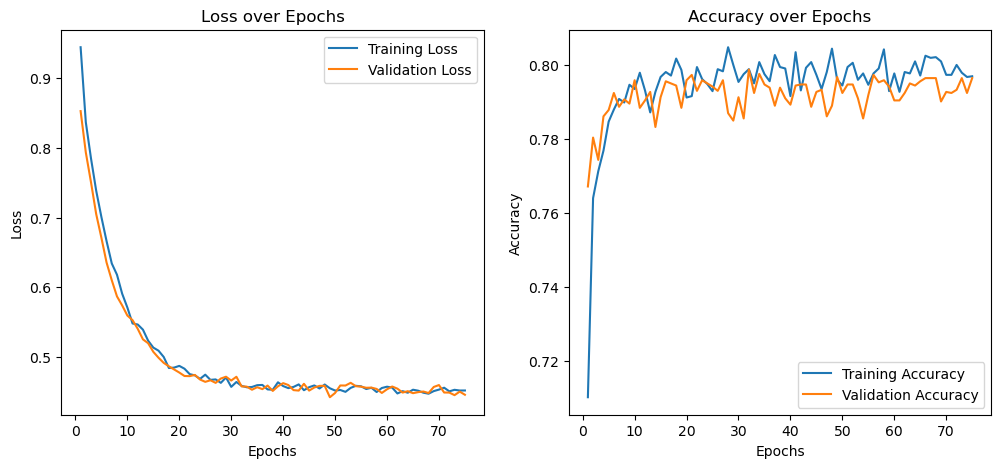

In [215]:
# Extracting loss and accuracy from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

**Observations:**
- The loss decreases steadily over the epochs, indicating that the model is learning.
- Training and validation loss are closely aligned, suggesting minimal overfitting.
- After ~30 epochs, the loss stabilizes, implying that the model has converged.
- The accuracy increases sharply at the beginning and then stabilizes.
- Training and validation accuracy fluctuate but stay close to each other, suggesting no major overfitting.
- The model achieves around 80% accuracy, which appears to be the performance ceiling.

**Key Takeaways**
- The model is well-trained and generalizes well, as there is no significant gap between training and validation performance.
- Loss and accuracy curves are smooth, with no abrupt jumps, indicating stable training.
- After ~30 epochs, improvements are minimal, suggesting that early stopping could be considered to save training time.


## Permutation Importance

Permutation importance is a technique used to evaluate the significance of individual features (or inputs) in a predictive model, including deep learning models. It provides a way to measure how much each feature contributes to the model's performance by assessing the impact of randomly shuffling (or permuting) that feature's values while keeping all other features unchanged. The idea is that if a feature is important, disrupting its values should significantly degrade the model's predictive power, whereas shuffling an unimportant feature should have little effect.


In [218]:
# Drop the Taransported columns for permutation importance
df_train_processed.drop(columns='Transported', inplace=True)

In [219]:
# Get feature names
feature_names = list(df_train_processed.columns)  # Replace `original_dataframe` with your actual DataFrame

# Get model predictions (continuous values)
y_pred_prob = dl_model_2.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Threshold at 0.5

# Compute permutation importance using a custom scorer
def custom_scorer(model, X, y):
    y_pred_prob = model.predict(X)  # Get probabilities
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert to binary
    return np.mean(y == y_pred)  # Compute accuracy

# Compute permutation importance
result = permutation_importance(dl_model_2, X_test, y_test, scoring=custom_scorer, n_repeats=10, random_state=42)

# Get feature names
feature_names = list(df_train_processed.columns)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': df_train_processed.columns,
    'Importance': result.importances_mean
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━

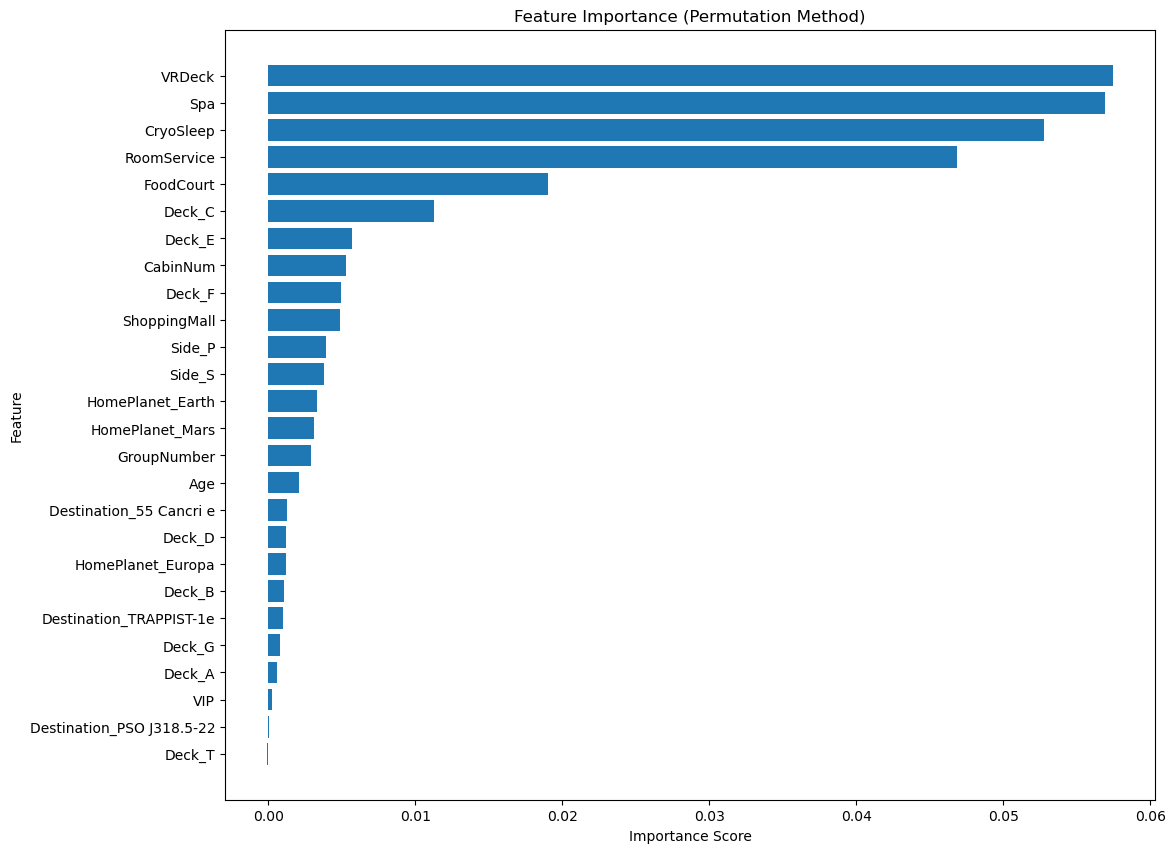

In [220]:
# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (Permutation Method)')
plt.gca().invert_yaxis()
plt.show()


Key Takeaways from the Graph:
1. Top Influential Features:
    - Spa, VRDeck, CryoSleep, RoomService, FoodCourt are the most important features in the model.
    - These represent spending behavior and passenger status, which appear to have a strong impact on predictions.
    - Passengers in CryoSleep likely do not spend money, which may strongly influence predictions.
2. Mid-Tier Features:
    - Deck (C, E, F, G), HomePlanet_Mars, CabinNum, ShoppingMall
    - These might indicate location-based trends (e.g., passengers from Mars or specific decks have different spending habits or survival chances).
3. Less Important Features:
    - Destination (TRAPPIST-1e, 55 Cancri e, PSO J318.5-22), VIP, GroupNumber, HomePlanet_Europa
    - These features have near-zero importance, suggesting that passenger destination and group size do not significantly affect the model’s predictions.

Possible Insights for the Business/Problem Context:
- Spending patterns (Spa, VRDeck, RoomService, FoodCourt) seem highly predictive, suggesting that financial behavior may be a key factor in determining the target outcome.
- CryoSleep is highly predictive, possibly because it directly influences whether passengers spend money or not.
- Deck and HomePlanet also contribute, indicating potential location-based influences on outcomes.
- VIP status is not very influential, which may indicate that VIP passengers behave similarly to non-VIP passengers in the dataset.


## SHAP

PermutationExplainer explainer: 3479it [19:37,  2.93it/s]                          


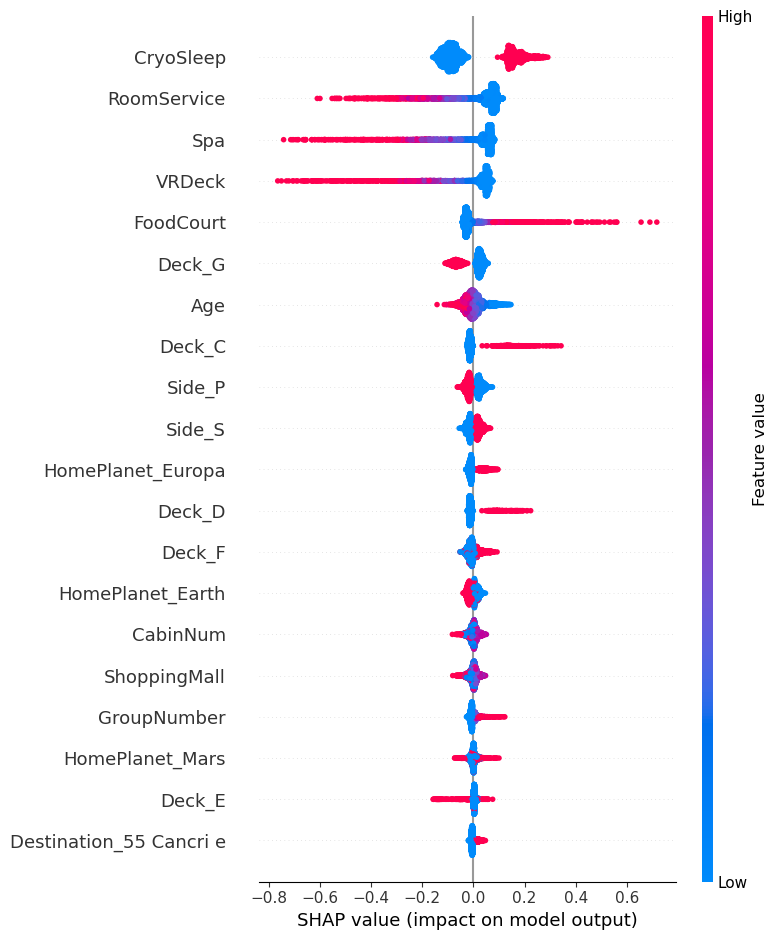

In [223]:
import shap

# Ensure feature names are retained
feature_names = df_train_processed.columns.tolist()  

# Convert X_train from NumPy array to DataFrame
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Create SHAP explainer
explainer = shap.Explainer(dl_model_2, X_train_df)

# Compute SHAP values
shap_values = explainer(X_test_df)

# Plot summary with feature names
shap.summary_plot(shap_values, X_test_df)

Insights from This Plot:  

Most Important Features
1. CryoSleep (Top Feature)
    - Blue (Low CryoSleep values) → Increases predictions (positive SHAP value).
    - Red (High CryoSleep values) → Decreases predictions (negative SHAP value).
    - Interpretation: Passengers in CryoSleep are less likely to belong to the predicted class (e.g., they spent less money, affecting survival or another target).
2. RoomService, Spa, VRDeck
    - Higher spending (Red) → Increases model prediction.
    - Lower spending (Blue) → Decreases model prediction.
    - Interpretation: Passengers who spend more in these categories have a stronger influence on the target variable (e.g., survival or classification outcome).
3. Deck_G and FoodCourt
    - Deck_G (Red = Higher values) → Increases predictions.
    - FoodCourt (Red = Higher spending) → Increases predictions.
    - Interpretation: Passengers on certain decks or with high FoodCourt spending may have a different probability of being in the target class.

# Feature Engineering

Total Spending Feature:   
Passengers in CryoSleep spend $0 on all services. So I'll create a new feature that sums up all spending categories.

In [227]:
df_train['TotalSpending'] = df_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

Spending per Category (Binary):  
Create binary indicators for whether a passenger spent money in each category (0 if no spending, 1 if spent).

In [229]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in spending_cols:
    df_train[col + '_Spent'] = (df_train[col] > 0).astype(int)

Spending Relative to Cabin or Deck:  
Normalize spending by the Cabin number or Deck to see if passengers on certain decks have different spending habits.

In [231]:
df_train['SpendingPerDeck_A'] = df_train.groupby('Deck_A')['TotalSpending'].transform(lambda x: x / x.mean())
df_train['SpendingPerDeck_B'] = df_train.groupby('Deck_B')['TotalSpending'].transform(lambda x: x / x.mean())
df_train['SpendingPerDeck_C'] = df_train.groupby('Deck_C')['TotalSpending'].transform(lambda x: x / x.mean())
df_train['SpendingPerDeck_D'] = df_train.groupby('Deck_D')['TotalSpending'].transform(lambda x: x / x.mean())
df_train['SpendingPerDeck_E'] = df_train.groupby('Deck_E')['TotalSpending'].transform(lambda x: x / x.mean())
df_train['SpendingPerDeck_F'] = df_train.groupby('Deck_F')['TotalSpending'].transform(lambda x: x / x.mean())
df_train['SpendingPerDeck_G'] = df_train.groupby('Deck_G')['TotalSpending'].transform(lambda x: x / x.mean())
df_train['SpendingPerDeck_T'] = df_train.groupby('Deck_T')['TotalSpending'].transform(lambda x: x / x.mean())

Group Size Indicator:  
If passengers are traveling in groups, this could impact their likelihood of being transported:

In [233]:
df_train['GroupSize'] = df_train.groupby('GroupNumber')['GroupNumber'].transform('count')

Has Cabin Roommate (Binary):  
Passengers with shared cabins may have different transport outcomes

In [235]:
df_train['HasRoommate'] = df_train.duplicated(subset=['CabinNum'], keep=False).astype(int)

In [236]:
# Check the dataframe for additional feature columns
df_train.head().T

,0,1,2,3,4
CryoSleep,0.0,0.000000,0.000000,0.000000,0.000000
Age,39.0,24.000000,58.000000,33.000000,16.000000
VIP,0.0,0.000000,1.000000,0.000000,0.000000
RoomService,0.0,109.000000,43.000000,0.000000,303.000000
FoodCourt,0.0,9.000000,3576.000000,1283.000000,70.000000
ShoppingMall,0.0,0.000000,0.000000,0.000000,1.000000
Spa,0.0,549.000000,6715.000000,3329.000000,565.000000
VRDeck,0.0,44.000000,49.000000,193.000000,2.000000
GroupNumber,1.0,1.000000,1.000000,2.000000,1.000000
CabinNum,0.0,0.000000,0.000000,0.000000,1.000000


# Train, Test, Split 2

In [238]:
X = df_train # Features

In [239]:
# Split the data into training and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [240]:
scaler = StandardScaler()

In [241]:
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Deep Learning 3

In [243]:
dl_model_3 = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    
    Dense(512, kernel_regularizer=l2(0.001)),  # More neurons + L2 Regularization
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(128, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(64, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(16, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with Adam optimizer
dl_model_3.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),  # Tuned learning rate
    metrics=['accuracy']
)

# Train the model
history = dl_model_3.fit(
    X_train, y_train,
    epochs=75,  # More epochs for deeper network
    batch_size=64,  # Increased batch size
    validation_data=(X_test, y_test)
)

Epoch 1/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6694 - loss: 1.0432 - val_accuracy: 0.7821 - val_loss: 0.8632
Epoch 2/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7745 - loss: 0.8679 - val_accuracy: 0.7867 - val_loss: 0.7990
Epoch 3/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7890 - loss: 0.8048 - val_accuracy: 0.7841 - val_loss: 0.7546
Epoch 4/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7875 - loss: 0.7510 - val_accuracy: 0.7913 - val_loss: 0.7103
Epoch 5/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7968 - loss: 0.6960 - val_accuracy: 0.7907 - val_loss: 0.6774
Epoch 6/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7957 - loss: 0.6680 - val_accuracy: 0.7959 - val_loss: 0.6453
Epoch 7/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7842 - loss: 0.6578 - val_accuracy: 0.7936 - val_loss: 0.6181
Epoch 8/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7989 - loss: 0.6187 - val_accuracy: 0.7956 - val_loss

In [244]:
# Make predictions on training and test data
y_train_pred = (dl_model_3.predict(X_train) > 0.5).astype('int32')
y_test_pred = (dl_model_3.predict(X_test) > 0.5).astype('int32')

# Print classification report for Training Data
print("Classification Report - Training Data:\n")
print(classification_report(y_train, y_train_pred))

# Print classification report for Test Data
print("Classification Report - Test Data:\n")
print(classification_report(y_test, y_test_pred))

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Classification Report - Training Data:

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2589
           1       0.81      0.83      0.82      2626

    accuracy                           0.82      5215
   macro avg       0.82      0.82      0.82      5215
weighted avg       0.82      0.82      0.82      5215

Classification Report - Test Data:

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1726
           1       0.80      0.81      0.80      1752

    accuracy                           0.80      3478
   macro avg       0.80      0.80      0.80      3478
weighted avg       0.80      0.80      0.80      3478



In [245]:
df_train_processed_2 = df_train

In [246]:
# Get feature names
feature_names = list(df_train_processed_2.columns)  # Replace `original_dataframe` with your actual DataFrame

# Get model predictions (continuous values)
y_pred_prob = dl_model_3.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Threshold at 0.5

# Compute permutation importance using a custom scorer
def custom_scorer(model, X, y):
    y_pred_prob = model.predict(X)  # Get probabilities
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert to binary
    return np.mean(y == y_pred)  # Compute accuracy

# Compute permutation importance
result = permutation_importance(dl_model_3, X_test, y_test, scoring=custom_scorer, n_repeats=10, random_state=42)

# Get feature names
feature_names = list(df_train_processed_2.columns)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': df_train_processed_2.columns,
    'Importance': result.importances_mean
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━

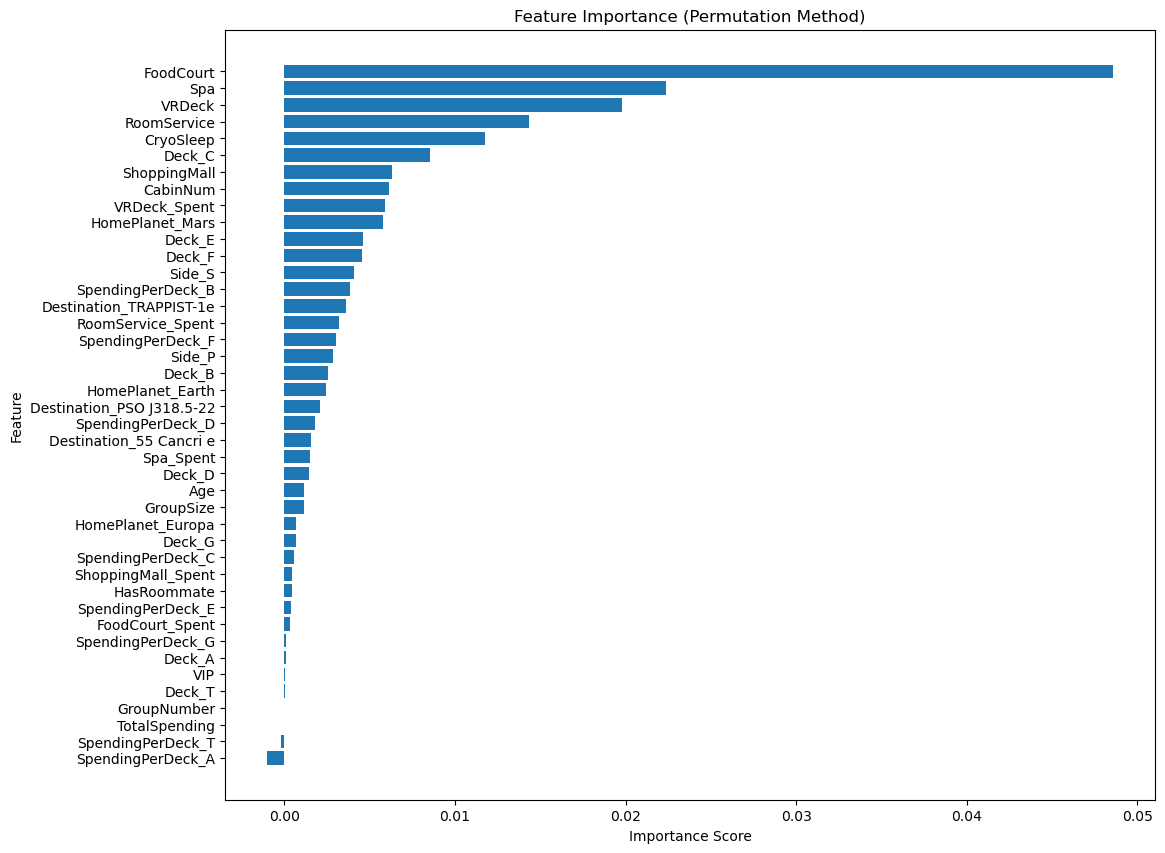

In [247]:
# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (Permutation Method)')
plt.gca().invert_yaxis()
plt.show()


## Feature Engineering from the Food Court Column

FoodCourt Spender (Binary):  
Indicates whether the passenger spent money at the FoodCourt (1) or not (0).

In [250]:
df_train['FoodCourt_Spent'] = (df_train['FoodCourt'] > 0).astype(int)

FoodCourt Spending Ratio:  
Compares FoodCourt spending to the total spending to see what proportion of a passenger’s money was spent at the FoodCourt.

In [252]:
df_train['FoodCourt_Ratio'] = df_train['FoodCourt'] / df_train['TotalSpending']
df_train['FoodCourt_Ratio'] = df_train['FoodCourt_Ratio'].fillna(0)  # Handle division by zero

FoodCourt Spending Relative to HomePlanet:  
Calculates the average FoodCourt spending per home planet and compares each passenger’s spending to that.

In [254]:
df_train['FoodCourt_Per_HomePlanet_Earth'] = df_train.groupby('HomePlanet_Earth')['FoodCourt'].transform(lambda x: x / x.mean())
df_train['FoodCourt_Per_HomePlanet_Earth'] = df_train['FoodCourt_Per_HomePlanet_Earth'].fillna(1)  # Normalize NaN values

df_train['FoodCourt_Per_HomePlanet_Europa'] = df_train.groupby('HomePlanet_Europa')['FoodCourt'].transform(lambda x: x / x.mean())
df_train['FoodCourt_Per_HomePlanet_Europa'] = df_train['FoodCourt_Per_HomePlanet_Europa'].fillna(1)  # Normalize NaN values

df_train['FoodCourt_Per_HomePlanet_Mars'] = df_train.groupby('HomePlanet_Mars')['FoodCourt'].transform(lambda x: x / x.mean())
df_train['FoodCourt_Per_HomePlanet_Mars'] = df_train['FoodCourt_Per_HomePlanet_Mars'].fillna(1)  # Normalize NaN values

# Train, Test, Split 3

In [256]:
X = df_train # Features

In [257]:
# Split the data into training and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [258]:
scaler = StandardScaler()

In [259]:
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [260]:
X_train.shape

(5215, 46)

In [261]:
X_test.shape

(3478, 46)

In [262]:
X.shape

(8693, 46)

# Deep Learning 4

In [264]:
dl_model_4 = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    
    Dense(512, kernel_regularizer=l2(0.001)),  # More neurons + L2 Regularization
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(128, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(64, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(16, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with Adam optimizer
dl_model_4.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),  # Tuned learning rate
    metrics=['accuracy']
)

# Train the model
history = dl_model_4.fit(
    X_train, y_train,
    epochs=75,  # More epochs for deeper network
    batch_size=64,  # Increased batch size
    validation_data=(X_test, y_test)
)

Epoch 1/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6821 - loss: 1.0260 - val_accuracy: 0.7887 - val_loss: 0.8562
Epoch 2/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7686 - loss: 0.8682 - val_accuracy: 0.7898 - val_loss: 0.7929
Epoch 3/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7805 - loss: 0.7969 - val_accuracy: 0.7812 - val_loss: 0.7444
Epoch 4/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7963 - loss: 0.7344 - val_accuracy: 0.7947 - val_loss: 0.6981
Epoch 5/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7992 - loss: 0.6870 - val_accuracy: 0.7915 - val_loss: 0.6591
Epoch 6/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7849 - loss: 0.6662 - val_accuracy: 0.7855 - val_loss: 0.6259
Epoch 7/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7810 - loss: 0.6331 - val_accuracy: 0.7959 - val_loss: 0.5991
Epoch 8/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7984 - loss: 0.5948 - val_accuracy: 0.7976 - val_loss:

In [265]:
# Make predictions on training and test data
y_train_pred = (dl_model_4.predict(X_train) > 0.5).astype('int32')
y_test_pred = (dl_model_4.predict(X_test) > 0.5).astype('int32')

# Print classification report for Training Data
print("Classification Report - Training Data:\n")
print(classification_report(y_train, y_train_pred))

# Print classification report for Test Data
print("Classification Report - Test Data:\n")
print(classification_report(y_test, y_test_pred))

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Classification Report - Training Data:

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2589
           1       0.82      0.82      0.82      2626

    accuracy                           0.82      5215
   macro avg       0.82      0.82      0.82      5215
weighted avg       0.82      0.82      0.82      5215

Classification Report - Test Data:

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1726
           1       0.81      0.79      0.80      1752

    accuracy                           0.80      3478
   macro avg       0.80      0.80      0.80      3478
weighted avg       0.80      0.80      0.80      3478



In [266]:
df_train_processed_3 = df_train

## Feature Importance

In [267]:
# Get feature names
feature_names = list(df_train_processed_3.columns)  # Replace `original_dataframe` with your actual DataFrame

# Get model predictions (continuous values)
y_pred_prob = dl_model_4.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Threshold at 0.5

# Compute permutation importance using a custom scorer
def custom_scorer(model, X, y):
    y_pred_prob = model.predict(X)  # Get probabilities
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert to binary
    return np.mean(y == y_pred)  # Compute accuracy

# Compute permutation importance
result = permutation_importance(dl_model_4, X_test, y_test, scoring=custom_scorer, n_repeats=10, random_state=42)

# Get feature names
feature_names = list(df_train_processed_3.columns)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': df_train_processed_3.columns,
    'Importance': result.importances_mean
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
109/109 ━━━━━━━

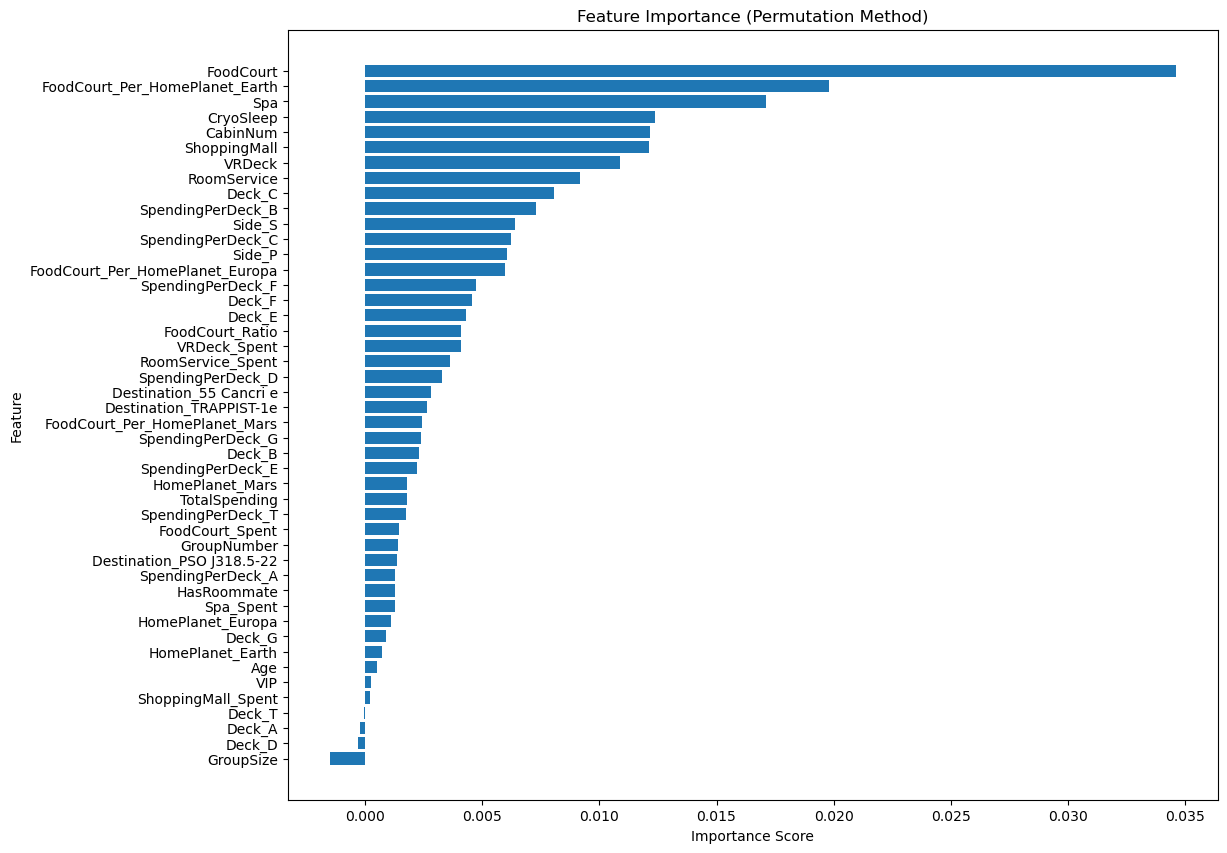

In [268]:
# Plot feature importances
plt.figure(figsize=(12, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (Permutation Method)')
plt.gca().invert_yaxis()
plt.show()


## SHAP Graph

PermutationExplainer explainer: 3479it [19:48,  2.90it/s]                          


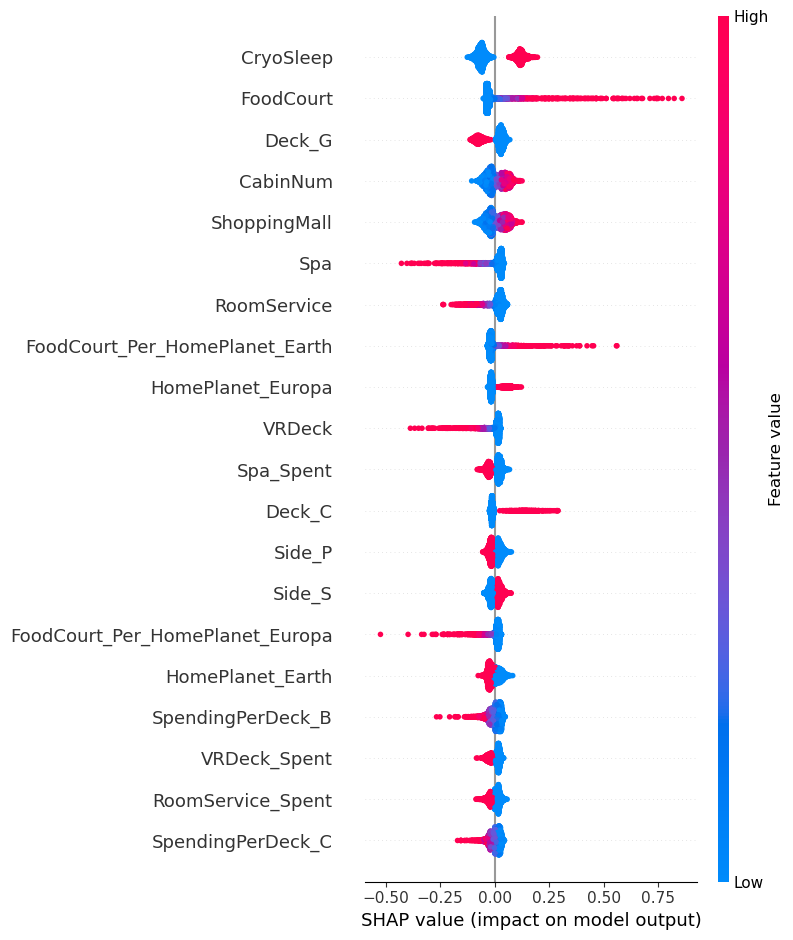

In [269]:
# Ensure feature names are retained
feature_names = df_train_processed_3.columns.tolist()  

# Convert X_train from NumPy array to DataFrame
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Create SHAP explainer
explainer = shap.Explainer(dl_model_4, X_train_df)

# Compute SHAP values
shap_values = explainer(X_test_df)

# Plot summary with feature names
shap.summary_plot(shap_values, X_test_df)

Observations:  
- CryoSleep has a strong influence on predictions – if the feature is high (red), it has a large positive impact, and if low (blue), it has a negative impact.
- Features like FoodCourt, Deck_G, and CabinNum also show notable impact on the model.
- Some features (e.g., RoomService_Spent, SpendingPerDeck_C) have a more centered impact, indicating they influence the model but do not drastically shift predictions.
- Features like Deck_C have a skewed distribution, suggesting strong influence when specific conditions are met.

# Process the Test Dataframe

In [271]:
df_test_orig = df_test

In [272]:
df_test.head().T

,0,1,2,3,4
PassengerId,0013_01,0018_01,0019_01,0021_01,0023_01
HomePlanet,Earth,Earth,Europa,Europa,Earth
CryoSleep,True,False,True,False,False
Cabin,G/3/S,F/4/S,C/0/S,C/1/S,F/5/S
Destination,TRAPPIST-1e,TRAPPIST-1e,55 Cancri e,TRAPPIST-1e,TRAPPIST-1e
Age,27.0,19.0,31.0,38.0,20.0
VIP,False,False,False,False,False
RoomService,0.0,0.0,0.0,0.0,10.0
FoodCourt,0.0,9.0,0.0,6652.0,0.0
ShoppingMall,0.0,0.0,0.0,0.0,635.0


## Fill in the Missing Values

In [274]:
# Split the group number from the passenger ID into a new column
df_test[['PassengerID', 'GroupNumber']] = df_test['PassengerId'].str.split('_', expand=True)

# Split the Cabin column into Deck, Num, and Side
df_test[['Deck', 'CabinNum', 'Side']] = df_test['Cabin'].str.split('/', expand=True)

# Convert CabinNum to numeric (optional)
df_test['CabinNum'] = pd.to_numeric(df_test['CabinNum'], errors='coerce')

# Drop the Cabin column
df_test = df_test.drop(columns='Cabin')

# Group by 'GroupNumber' and fill NaN in 'HomePlanet' with the most common value within each group
df_test['HomePlanet'] = df_test.groupby(['GroupNumber'])['HomePlanet'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)

# Filling missing values of the cryosleep column in the test dataframe
df_test['CryoSleep'] = df_test.groupby(['HomePlanet', 'GroupNumber'])['CryoSleep'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

# Fill the missing values with the Mode of the previous groupby
df_test['Destination'] = df_test.groupby(['HomePlanet','CryoSleep'])['Destination'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

# Fill NaN values in 'Age' with the median age within each group defined by HomePlanet, Destination, and Deck
df_test['Age'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep'])['Age'] \
                          .transform(lambda x: x.fillna(x.median()))

# Fill the missing values with the Mode of the previous groupby
df_test['Deck'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep','Destination'])['Deck'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

# Fill the missing values with the Mode of the previous groupby
df_test['Side'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep','Destination', 'Deck'])['Side'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

# Fill the missing values with the Mode of the previous groupby
df_test['CabinNum'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep', 'Destination', 'Deck', 'Side'])['CabinNum'] \
                          .transform(lambda x: x.fillna(x.median()))

# If the NaN value has True in the Cryosleep column then fill it with False
df_test.loc[(df_test['CryoSleep'] == True) & (df_test['VIP'].isna()), 'VIP'] = False

# Fill the missing values with the Mode of the groupby
df_test['VIP'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'CryoSleep', 'Deck'])['VIP'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x).infer_objects(copy=False)

# If the NaN value has True in the Cryosleep column then fill it with False in the Room Service column
df_test.loc[(df_train['CryoSleep'] == True) & (df_test['RoomService'].isna()), 'RoomService'] = 0 

# Fill the missing values with the Mode of the previous groupby
df_test['RoomService'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'Destination', 'Deck', 'Side'])['RoomService'] \
                          .transform(lambda x: x.fillna(x.median()))

# If the NaN value has True in the Cryosleep column then fill it with False in the Food Court column
df_test.loc[(df_train['FoodCourt'] == True) & (df_test['FoodCourt'].isna()), 'FoodCourt'] = 0

# Fill the missing values with the Mode of the groupby
df_test['FoodCourt'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'Deck', 'Side'])['FoodCourt'] \
                          .transform(lambda x: x.fillna(x.median()))

df_test['FoodCourt'] = df_test['FoodCourt'].fillna(0.0)

# Fill the missing values with the Mode
df_test['ShoppingMall'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'Deck', 'Side'])['CabinNum'] \
                          .transform(lambda x: x.fillna(x.median()))

# Fill the missing values based on the Cryosleep column. If its True then Spa NaN value is 0
df_test.loc[(df_train['CryoSleep'] == True) & (df_test['Spa'].isna()), 'Spa'] = 0

# Fill the missing values with the Median groupby
df_test['Spa'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'Deck'])['Spa'] \
                          .transform(lambda x: x.fillna(x.median()))
df_test['Spa'] = df_test['Spa'].fillna(0.0)

df_test.loc[(df_train['CryoSleep'] == True) & (df_test['VRDeck'].isna()), 'VRDeck'] = 0

# Fill the missing values with the Mode
df_test['VRDeck'] = df_test.groupby(['HomePlanet', 'GroupNumber', 'Deck', 'Side'])['VRDeck'] \
                          .transform(lambda x: x.fillna(x.median()))

# Fill the last NaN value with the Mode 0.0
df_test['VRDeck'] = df_test['VRDeck'].fillna(0.0)

# Drop the Name column
df_test.drop(columns='Name', inplace=True)

In [275]:
df_test.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
PassengerID     0
GroupNumber     0
Deck            0
CabinNum        0
Side            0
dtype: int64

## Outliers

In [277]:
# Define the threshold for Room Service values
threshold = 8000
new_value = 8000  # Value to replace Room Service above the threshold

# Modify values in the 'Room Service' column
df_test.loc[df_train['RoomService'] > threshold, 'RoomService'] = new_value

# Define the threshold for Food Court values
threshold = 20000
new_value = 20000 # Value to replace ages above the threshold

# Modify values in the 'Food Court' column
df_test.loc[df_train['FoodCourt'] > threshold, 'FoodCourt'] = new_value

# Define the threshold for Spa values
threshold = 15000
new_value = 15000 # Value to replace above the threshold

# Modify values in the 'Spa' column
df_test.loc[df_train['Spa'] > threshold, 'Spa'] = new_value

# Define the threshold
threshold = 14000
new_value = 14000 # Value to replace above the threshold

# Modify values in the 'VR Deck' column
df_test.loc[df_train['VRDeck'] > threshold, 'VRDeck'] = new_value

## Create Dummy Variables

In [279]:
# Create dummy variables from the Home Planet column
df_test = pd.get_dummies(df_test, columns=['HomePlanet'], drop_first=False)

# Convert the dummy variables to numerical
df_test['HomePlanet_Earth'] = df_test['HomePlanet_Earth'].astype(int)
df_test['HomePlanet_Europa'] = df_test['HomePlanet_Europa'].astype(int)
df_test['HomePlanet_Mars'] = df_test['HomePlanet_Mars'].astype(int)

# Create dummy variables
df_test = pd.get_dummies(df_test, columns=['Destination'], drop_first=False)

# Convert the dummy variables to numerical
df_test['Destination_55 Cancri e'] = df_test['Destination_55 Cancri e'].astype(int)
df_test['Destination_PSO J318.5-22'] = df_test['Destination_PSO J318.5-22'].astype(int)
df_test['Destination_TRAPPIST-1e'] = df_test['Destination_TRAPPIST-1e'].astype(int)

# Convert GroupNumber column to numerical
df_test['GroupNumber'] = df_test['GroupNumber'].astype(int)

# Create dummy variables
df_test = pd.get_dummies(df_test, columns=['Deck'], drop_first=False)

# Convert the columns to numerical
df_test['Deck_A'] = df_test['Deck_A'].astype(int)
df_test['Deck_B'] = df_test['Deck_B'].astype(int)
df_test['Deck_C'] = df_test['Deck_C'].astype(int)
df_test['Deck_D'] = df_test['Deck_D'].astype(int)
df_test['Deck_E'] = df_test['Deck_E'].astype(int)
df_test['Deck_F'] = df_test['Deck_F'].astype(int)
df_test['Deck_G'] = df_test['Deck_G'].astype(int)
df_test['Deck_T'] = df_test['Deck_T'].astype(int)

# Create dummy variables
df_test= pd.get_dummies(df_test, columns=['Side'], drop_first=False)

# Convert the columns to numerical
df_test['Side_P'] = df_test['Side_P'].astype(int)
df_test['Side_S'] = df_test['Side_S'].astype(int)

# Convert the columns to numerical
df_test['CryoSleep'] = df_test['CryoSleep'].astype(int)
df_test['VIP'] = df_test['VIP'].astype(int)

df_test['PassengerID'] = df_test['PassengerID'].astype(int)

## Feature Engineering

Total Spending Feature:   
Passengers in CryoSleep spend $0 on all services. So I'll create a new feature that sums up all spending categories.

In [282]:
df_test['TotalSpending'] = df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

Spending per Category (Binary):  
Create binary indicators for whether a passenger spent money in each category (0 if no spending, 1 if spent).

In [284]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in spending_cols:
    df_test[col + '_Spent'] = (df_test[col] > 0).astype(int)

Spending Relative to Cabin or Deck:  
Normalize spending by the Cabin number or Deck to see if passengers on certain decks have different spending habits.

In [286]:
df_test['SpendingPerDeck_A'] = df_test.groupby('Deck_A')['TotalSpending'].transform(lambda x: x / x.mean())
df_test['SpendingPerDeck_B'] = df_test.groupby('Deck_B')['TotalSpending'].transform(lambda x: x / x.mean())
df_test['SpendingPerDeck_C'] = df_test.groupby('Deck_C')['TotalSpending'].transform(lambda x: x / x.mean())
df_test['SpendingPerDeck_D'] = df_test.groupby('Deck_D')['TotalSpending'].transform(lambda x: x / x.mean())
df_test['SpendingPerDeck_E'] = df_test.groupby('Deck_E')['TotalSpending'].transform(lambda x: x / x.mean())
df_test['SpendingPerDeck_F'] = df_test.groupby('Deck_F')['TotalSpending'].transform(lambda x: x / x.mean())
df_test['SpendingPerDeck_G'] = df_test.groupby('Deck_G')['TotalSpending'].transform(lambda x: x / x.mean())
df_test['SpendingPerDeck_T'] = df_test.groupby('Deck_T')['TotalSpending'].transform(lambda x: x / x.mean())

Group Size Indicator:  
If passengers are traveling in groups, this could impact their likelihood of being transported:

In [288]:
df_test['GroupSize'] = df_test.groupby('GroupNumber')['GroupNumber'].transform('count')

Has Cabin Roommate (Binary):  
Passengers with shared cabins may have different transport outcomes

In [290]:
df_test['HasRoommate'] = df_test.duplicated(subset=['CabinNum'], keep=False).astype(int)

FoodCourt Spender (Binary):  
Indicates whether the passenger spent money at the FoodCourt (1) or not (0).

In [292]:
df_test['FoodCourt_Spent'] = (df_test['FoodCourt'] > 0).astype(int)

FoodCourt Spending Ratio:  
Compares FoodCourt spending to the total spending to see what proportion of a passenger’s money was spent at the FoodCourt.

In [294]:
df_test['FoodCourt_Ratio'] = df_test['FoodCourt'] / df_test['TotalSpending']
df_test['FoodCourt_Ratio'] = df_test['FoodCourt_Ratio'].fillna(0)  # Handle division by zero

FoodCourt Spending Relative to HomePlanet:  
Calculates the average FoodCourt spending per home planet and compares each passenger’s spending to that.

In [296]:
df_test['FoodCourt_Per_HomePlanet_Earth'] = df_test.groupby('HomePlanet_Earth')['FoodCourt'].transform(lambda x: x / x.mean())
df_test['FoodCourt_Per_HomePlanet_Earth'] = df_test['FoodCourt_Per_HomePlanet_Earth'].fillna(1)  # Normalize NaN values

df_test['FoodCourt_Per_HomePlanet_Europa'] = df_test.groupby('HomePlanet_Europa')['FoodCourt'].transform(lambda x: x / x.mean())
df_test['FoodCourt_Per_HomePlanet_Europa'] = df_test['FoodCourt_Per_HomePlanet_Europa'].fillna(1)  # Normalize NaN values

df_test['FoodCourt_Per_HomePlanet_Mars'] = df_test.groupby('HomePlanet_Mars')['FoodCourt'].transform(lambda x: x / x.mean())
df_test['FoodCourt_Per_HomePlanet_Mars'] = df_test['FoodCourt_Per_HomePlanet_Mars'].fillna(1)  # Normalize NaN values

In [297]:
# Save PassengerID separately
passenger_ids_with_group = df_test['PassengerId']

In [298]:
# Drop the Passenger ID column
df_test.drop(columns='PassengerId', inplace=True)

In [299]:
df_test.head().T

,0,1,2,3,4
CryoSleep,1.000000,0.000000,1.0,0.000000,0.000000
Age,27.000000,19.000000,31.0,38.000000,20.000000
VIP,0.000000,0.000000,0.0,0.000000,0.000000
RoomService,0.000000,0.000000,0.0,0.000000,10.000000
FoodCourt,0.000000,9.000000,0.0,6652.000000,0.000000
ShoppingMall,3.000000,4.000000,0.0,1.000000,5.000000
Spa,0.000000,2823.000000,0.0,181.000000,0.000000
VRDeck,0.000000,0.000000,0.0,585.000000,0.000000
PassengerID,13.000000,18.000000,19.0,21.000000,23.000000
GroupNumber,1.000000,1.000000,1.0,1.000000,1.000000


# Submission CSV

In [301]:
# Save PassengerID separately
passenger_ids = df_test['PassengerID']

In [302]:
# Drop the Passenger ID column
df_test.drop(columns='PassengerID', inplace=True)

In [303]:
# Scale the test dataset
df_test = scaler.transform(df_test)

## Deep Learning Prediction and Submission

In [305]:
# Predict using the trained deep learning model
y_probs_dl = dl_model_4.predict(df_test)

# Apply the threshold
threshold = 0.5
y_pred_adjusted = (y_probs_dl >= threshold).astype(int)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [306]:
# Ensure y_pred_adjusted is a 1D array
y_pred_dl = y_pred_adjusted.flatten()  # Converts (n,1) to (n,)

# Convert predictions to boolean (assuming they are probabilities or 0/1)
submission_dl = pd.DataFrame({
    'PassengerId': passenger_ids_with_group, 
    'Transported': y_pred_dl.astype(bool)  # Convert to boolean
})

In [307]:
submission_dl['Transported'].value_counts()

Transported
True     2173
False    2104
Name: count, dtype: int64

In [308]:
submission_dl.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [309]:
# Export Deep Learning predictions to csv
submission_dl.to_csv('dobrenz_dl_spaceship_titanic_submission.csv', index=False)

In [310]:
submission_dl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


# **SUMMARY Conclusion**

**Data Preprocessing & Feature Engineering**
- Missing Values: Successfully filled missing values to ensure a complete dataset.
- Outliers: Identified and handled outliers to improve model stability.
- Dummy Variables: Created categorical feature encodings to enhance model interpretability.
    
**Model Development**
- Developed and tested four different deep learning models to compare performance.
- I tested alot more than is shown. All showed the same results. I even used hyperband to tune the deep learning models, again showing the same results. So, I focused on tuning by adding features as a way to improve the model. 
- Evaluated models using SHAP (SHapley Additive exPlanations) values and Permutation Feature Importance for feature interpretability.
**Key Findings**
1. Feature Importance:

    - FoodCourt spending emerged as the most influential feature, strongly affecting the model's predictions. Maybe someone spending more time in the Food Court had some sort of influence on whether or not someone got transported or not. 
    - Other key features include CryoSleep status, Spa, VRDeck, and RoomService expenses.
    - Features related to home planet and deck information also contributed significantly.
2. Model Performance:

    - The models achieved 82% accuracy on training data and 80% accuracy on test data.
    - Precision, recall, and F1-scores indicate a well-balanced model performance across both classes.
    - Slight performance drop in the test data suggests potential overfitting, but overall generalization is strong.
3. SHAP Analysis:  

    - Higher spending in categories like FoodCourt, Spa, and VRDeck generally increased model output.
    - Features like CryoSleep had a strong negative impact, indicating passengers in CryoSleep may exhibit different behavior. Which makes sense, because if someone were in CryoSleep for the trip, their behavior would be totally different than someone who wasn't.  
**Final Thoughts & Next Steps**
The model is robust and interpretable, with key features clearly influencing predictions.
- Further improvements could include:
    - Ensemble methods to boost performance.
    - Exploring additional engineered features, such as interaction effects between spending categories.  

Overall, this analysis provides valuable insights into the most critical factors influencing predictions for the Spaceship titanic dataset. 